<h1 style="color:rgb(0,120,170)">Cluster Analysis</h1>

This material, no matter whether in printed or electronic form, may be used for personal and non-commercial educational use only. Any reproduction of this material, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

<h3 style="color:rgb(0,120,170)">Task 1 (60 points):</h3> 

Complete the implementation of the $k$-means algorithm using the provided skeleton. 

You will have to implement:
* a) Initialization of the centers of the clusters
* b) Distance measure (Euclidean)
* c) Cluster assignment and loss computation
* d) Cluster center computation (mean and median)
* e) Convergence criterion function taking into account maximum number of iterations and changes in the clusters assignments
* f) Core part of the algorithm in the ```fit``` function

Plotting functions are provided.

You can of course ignore the skeleton and implement your own version of plotting functions and the $k$-means algorithm as long as the requirements 'a' to 'f' are fulfilled and the questions are correctly answered.

Use the data given in `cluster0.csv`. The third column of the data are the labels. Use them only to compare original labeling and results of the algorithm.

Tasks (short description):
* 1a: Run with different numbers of clusters from $k=3$ to $k=7$. Plot results and report loss value after convergence.
* 1b: For $k=5$, after each iteration, plot cluster assignments and report loss value.
* 1c: Run with two different methods of computing the centers of the clusters (mean and median). Additionally, for $k=4$ to $k=7$, plot the evolution of the loss across iterations until convergence.


In [1031]:
import numpy as np
import matplotlib.pyplot as plt
from math import ceil, sqrt

In [1032]:
# Load data and create the run function
data = np.loadtxt(open('cluster0.csv', 'r'), delimiter=',', skiprows=1)

X = data[:, :2] # Matrix of feature vectors
y = data[:, -1] # Target values (labels)
loss = 0

def run(k,dist,plot,method):
    '''
        Runs the algorithm.
        Returns the loss of the last iteration, and a list with the losses per iteration (for the last trial)
        @param int k: number of clusters
        @param string dist: distance measure ('Euclidean', 'Manhattan')
        @param string plot: what to plot ('plot_convergence', 'plot_all')
        @param int n_tries: number of trials 
        @param string method: method to compute the centers of the cluster 
    '''
    kmeans = KMeansClustering(k,dist,method)
    # Run k-means and plot intermediate steps
    loss = kmeans.fit(X, y, plot)
    return [loss,kmeans.loss_hist]


In [1119]:
colors = ['b', 'g', 'r', 'c', 'm', 'y','k', 'lightpink']
labels   = ['1','2','3','4','5','6','7','8']

def clusters_plot(clusters):
    n_clusters = len(clusters)
    assert n_clusters <= len(colors)
    
    i = 0
    for idx in range(n_clusters):
        cluster = clusters[idx]
        plt.scatter(cluster[0], cluster[1], color=colors[i], label=labels[idx], marker='o', s=200, edgecolor='k')
        i += 1
    
def plot_cluster_space(data, title = None, pts_to_clusters = {}, clusters = []):
    
    plt.figure(figsize=(10,10))
    n_clusters = len(clusters)
    assert n_clusters <= len(colors)
    
    i = 0
    for k in range(n_clusters):
        pts = pts_to_clusters[k]
        if not len(pts) == 0:
            d = np.array(pts_to_clusters[k])
            plt.scatter(d[:,0], d[:,1], color=colors[i], label=labels[k])
            
        i += 1
    
    if not title == None:
        plt.title(title)

    if n_clusters > 0:
        clusters_plot(clusters)
    
    plt.legend()
    plt.show()

In [1120]:
def center_initialization(data, i):
    
    data_min = np.min(data[:,i])
    data_max = np.max(data[:,i])
        
    
    centroids = np.random.uniform(np.ceil(data_min), np.ceil(data_max), 1)[0]
  
    return centroids

In [1121]:
def assign_points(data, clusters):
    
    def compute_distance(p1, p2):    
        if type(p1) == int:
            p1 = [ p1 ]
        if type(p2) == int:
            p2 = [ p2 ]

        ## euclidean method between two points,
        assert len(p1) == len(p2)
        distance = sqrt(np.sum([ (x1 - x2) ** 2 for x1, x2 in zip(p1, p2) ]))

        return distance 
    

    def points_to_a_cluster(instance, clusters):
        n_clusters = len(clusters)
        return np.argmin([compute_distance(instance, clusters[i]) for i in range(n_clusters)])
    
    points_in_cluster = dict([ (k, []) for k in range(len(clusters)) ])
    for row in data:
        cluster_pointed = points_to_a_cluster(row, clusters)
        points_in_cluster[cluster_pointed].append(row.tolist())
    return points_in_cluster



In [1122]:
def compute_centroid(cluster, mean_center = True):
    _, n_feat =X.shape;
    
    if mean_center:
        return [np.mean(np.array(cluster)[:, i]) for i in range(n_feat)]
    
    return [np.median(np.array(cluster)[:, i]) for i in range(n_feat)]

In [1123]:

def iteration_fit(X, max_iter,n_clusters, mean_center =True):
    
    ## pull initial clusters,
    num_cl = n_clusters
    _, n_feat = X.shape;
    clusters = [[center_initialization(X, i) for i in range(n_feat)]for _ in range(num_cl)]
    
    ## assign points to clusters, plot,
    iteration = 0
    cluster_to_pts = assign_points(X, clusters)
    plot_cluster_space(X, iteration, cluster_to_pts, clusters)

    prev_clusters = [ (iteration, clusters.copy())]
    
    loss_list = []

    for iteration in range(iteration+1, max_iter):
        ## update centroids/clusters
        clusters = [ compute_centroid(cluster_to_pts[i], mean_center) for i in range(0,num_cl)]

        ## re-assignment of points and then plot again
        cluster_to_pts = assign_points(X, clusters)
        plot_cluster_space(X, iteration, cluster_to_pts, clusters)

        prev_clusters.append((iteration, clusters.copy()))

        convergence_ = True
        for i in range(num_cl):
            if not np.sum(np.array(prev_clusters[-1][1][i]) - np.array(prev_clusters[-2][1][i])) == 0:
                
                loss_temp = np.sqrt(np.sum(np.array(prev_clusters[-1][1][i]) - np.array(prev_clusters[-2][1][i]))**2)
                
                print("Loss value is  " + str(loss_temp))
                
                loss_list.append(loss_temp)
    
                convergence_ = False
                break
                

        if convergence_:
            break
    
    return loss_list

In [1038]:
def split_labeled_set(X, y):
    '''
    Given a two-dimensional multiclass labeled dataset, with n classes, returns n single-class subsets
    @return dict: a dictionary with labels in its keys and subsets (matrices) for the given label in its values
    '''
    if X.shape[1] != 2:
        raise Exception("Can only plot two-dimensional datasets")
    labels = set(y)
    subsets = {}
    for l in labels:
        indices = np.where(y == l)[0]
        subset_x1 = X[:,0][indices]
        subset_x2 = X[:,1][indices]
        subset = np.column_stack((subset_x1, subset_x2))
        subsets[l] = subset
    return subsets

<h3 style="color:rgb(0,120,170)">Task 1a:</h3>

Run the algorithm for different numbers of clusters ($k$ = 3, 4, 5, 6 and 7) using the mean to compute the centers of the clusters.

For each $k$, plot the original labels and the results after convergence. Report also the final loss.

Questions:

* What do you observe?
* How does the final loss change using different $k$? Why?
* Do you get the same results if you run again? Why?


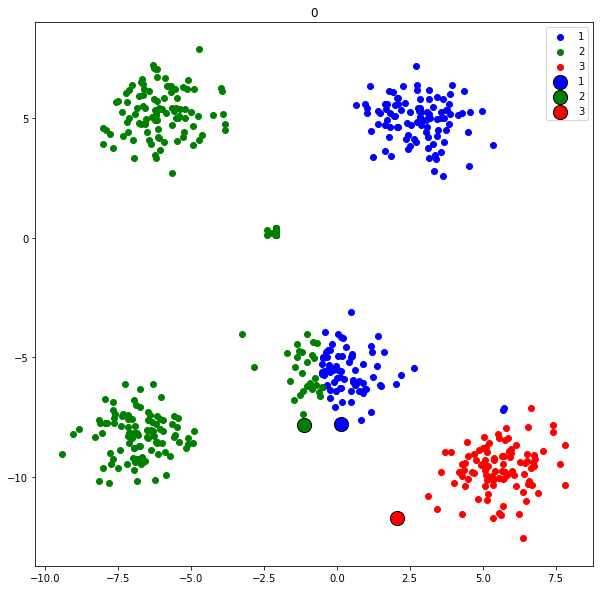

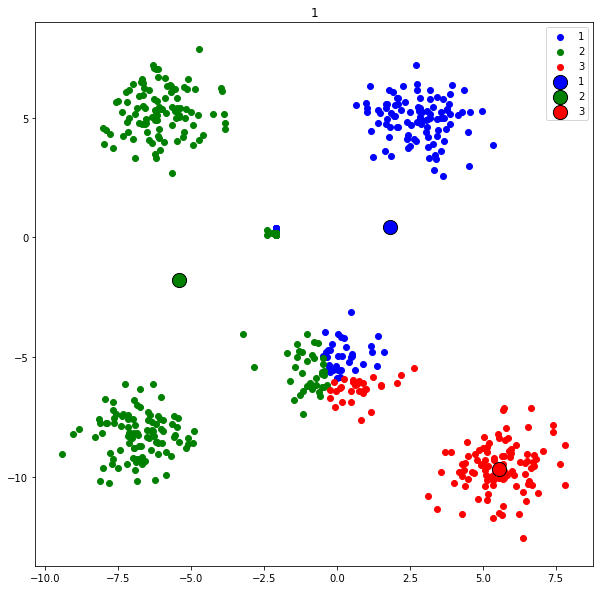

Loss value is  9.896618159346808


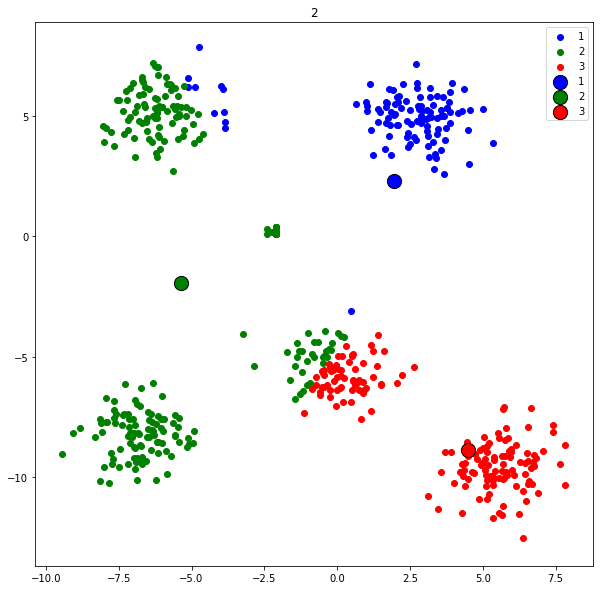

Loss value is  1.9718499049444518


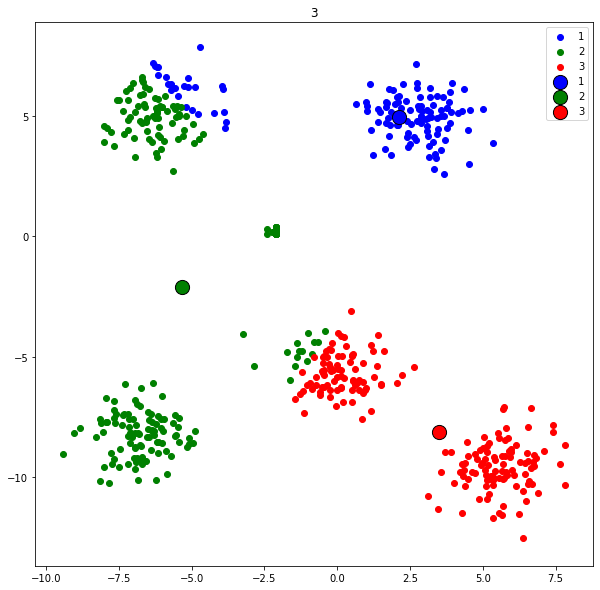

Loss value is  2.8287092644385066


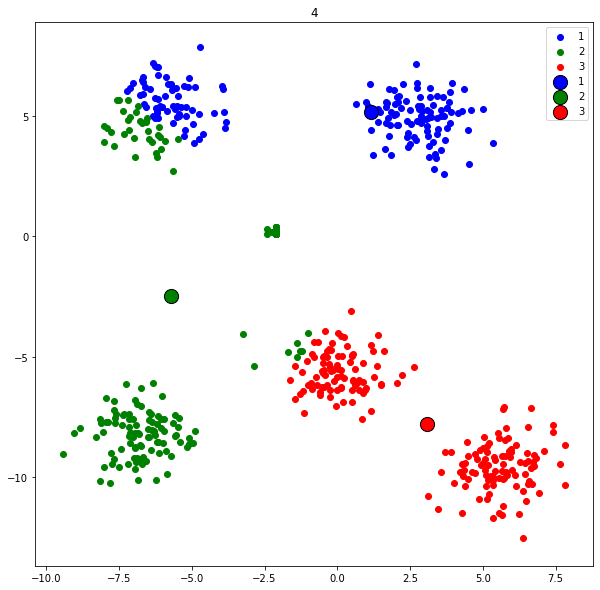

Loss value is  0.7439459341724581


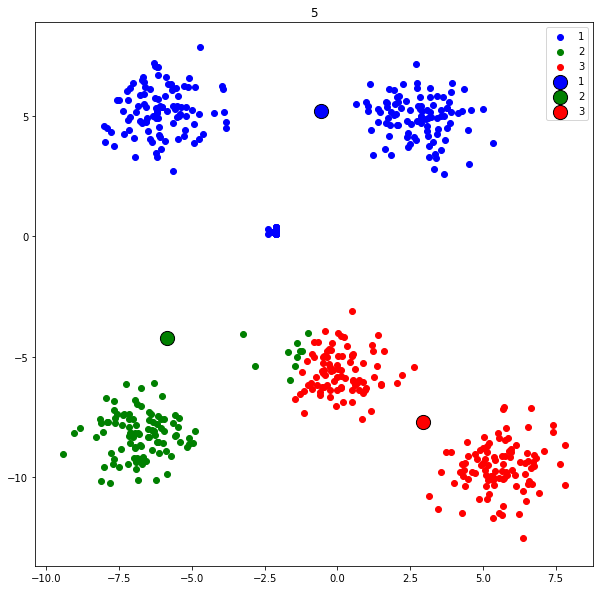

Loss value is  1.6781529895725753


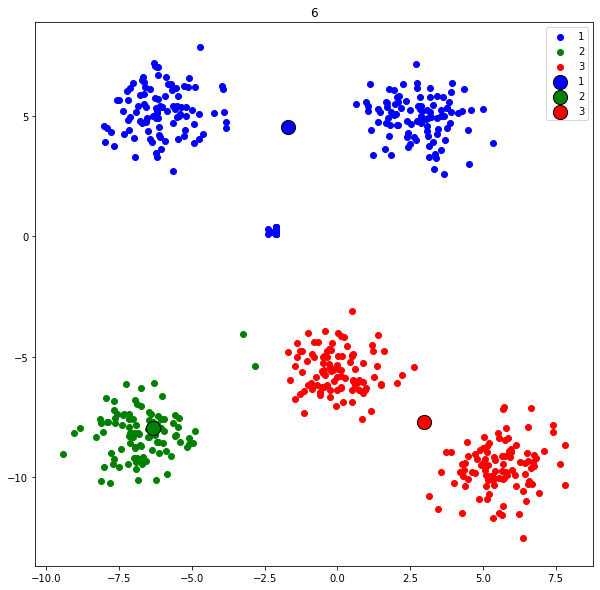

Loss value is  1.7954033742769484


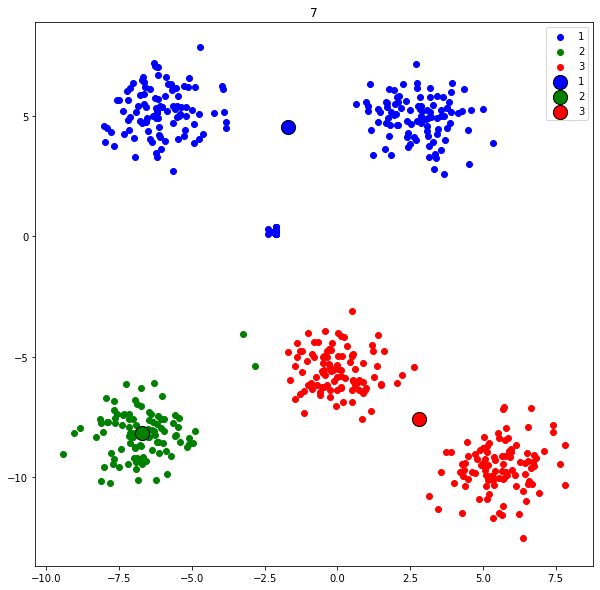

Loss value is  0.6273136876951888


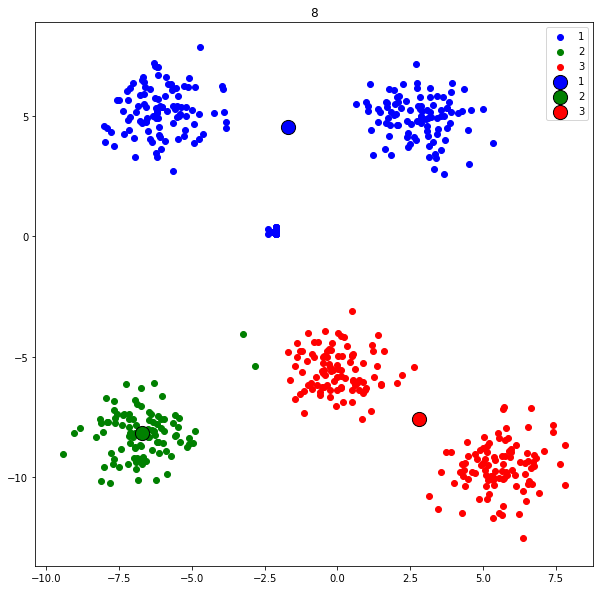

In [1039]:
# k =3

k_3_mean = iteration_fit(X,20,3,True)

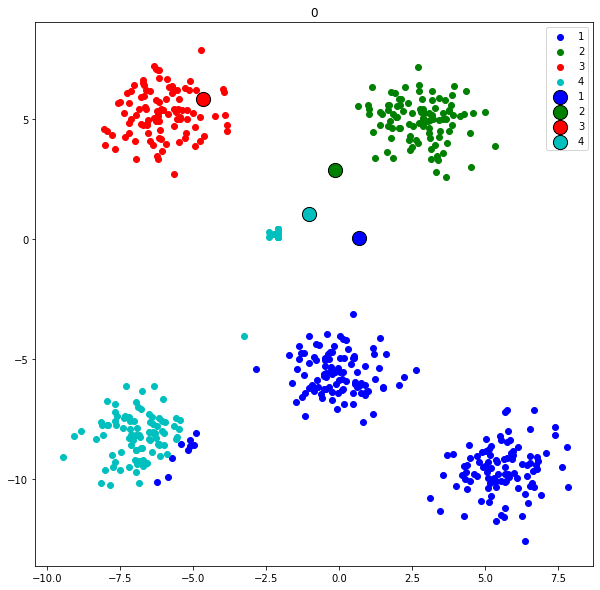

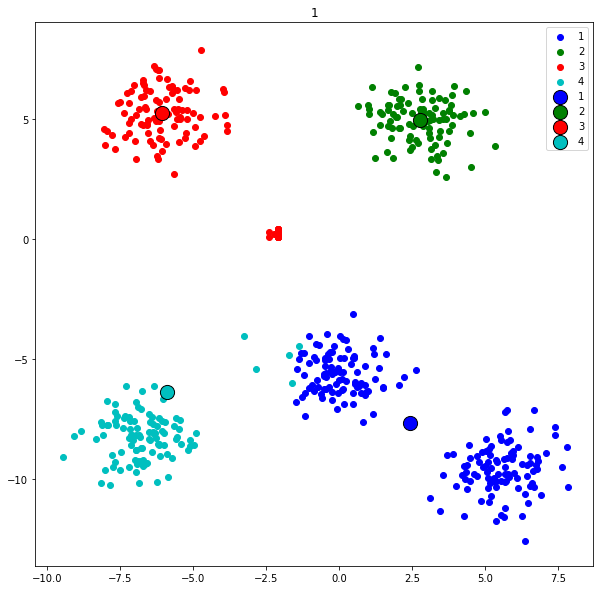

Loss value is  5.982150779466534


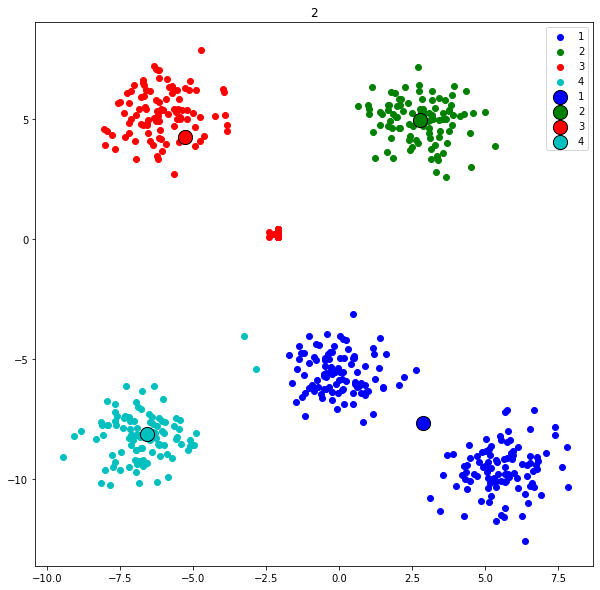

Loss value is  0.4549043526686658


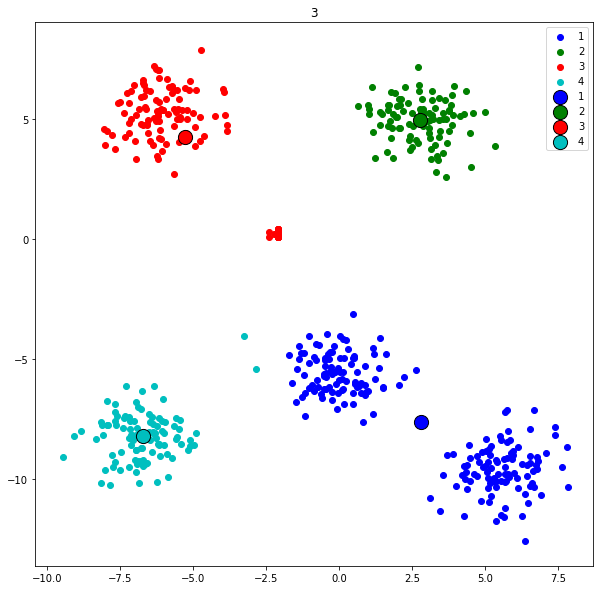

Loss value is  0.028356487651612028


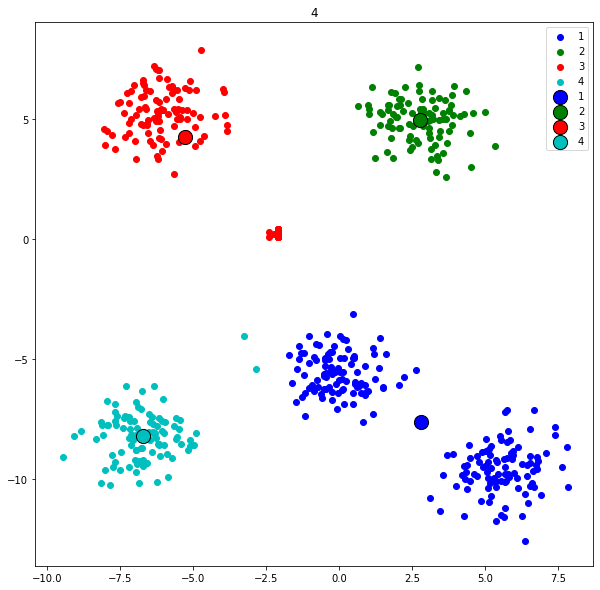

In [1040]:
# k =4 

k_4_mean = iteration_fit(X,20,4,True)

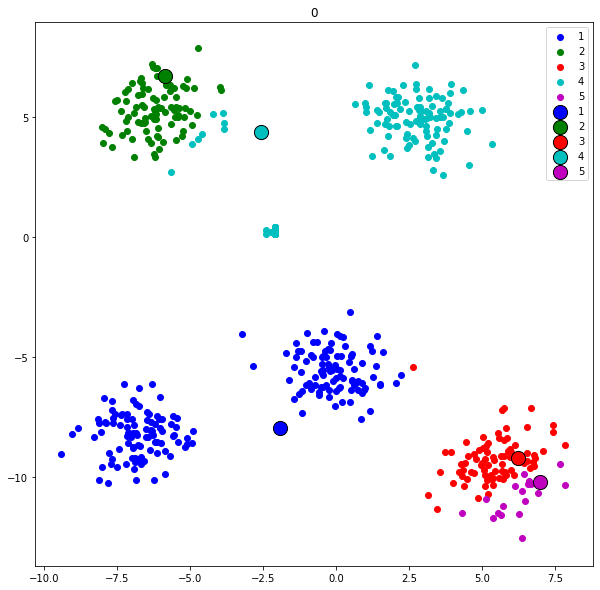

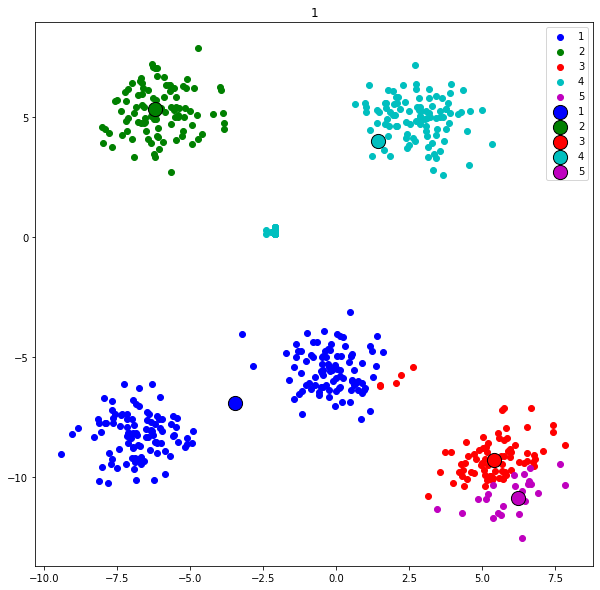

Loss value is  0.5045677258737387


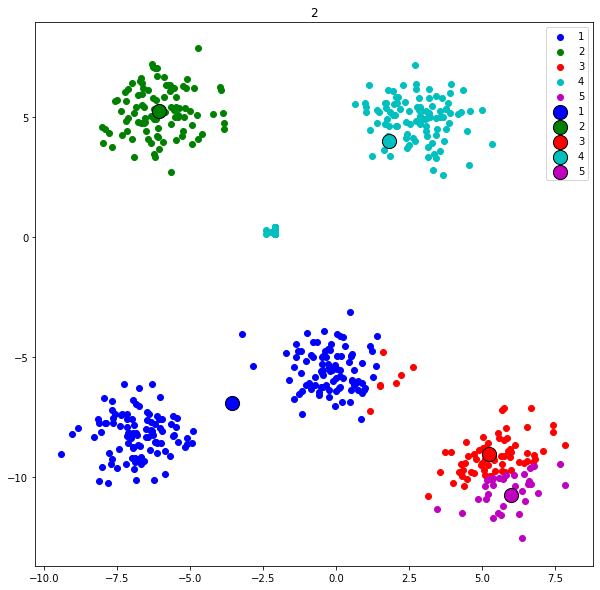

Loss value is  0.12610886721182935


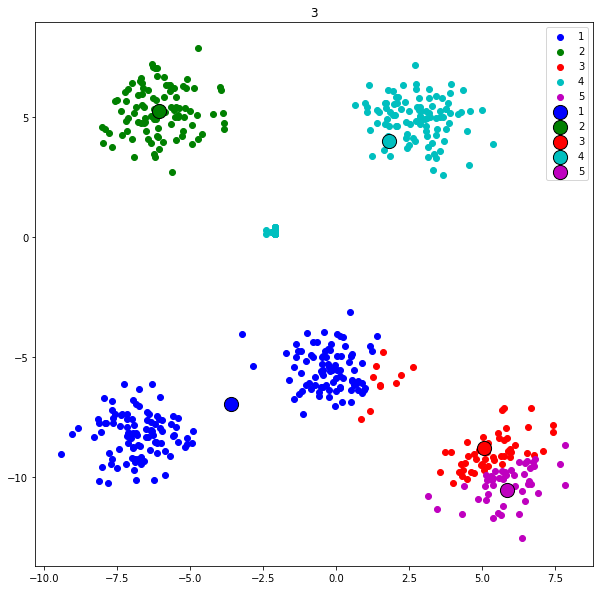

Loss value is  0.06078606952112464


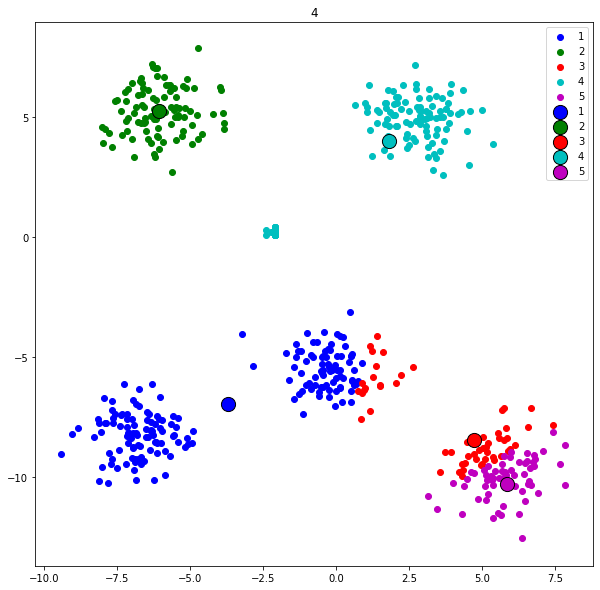

Loss value is  0.08594968512067958


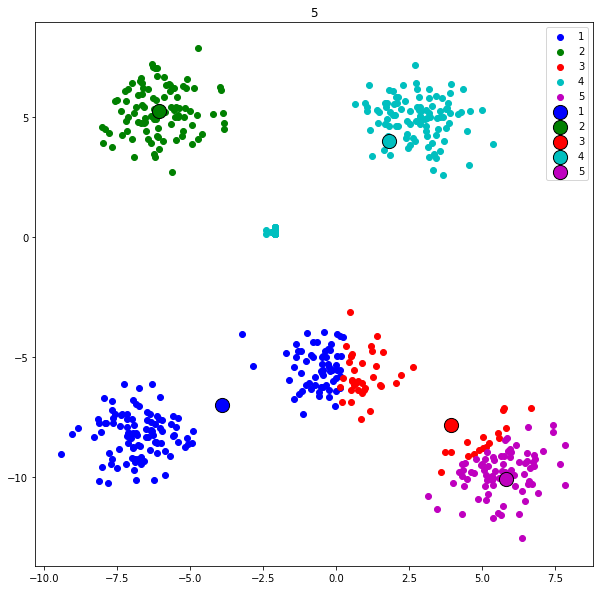

Loss value is  0.26586948733210525


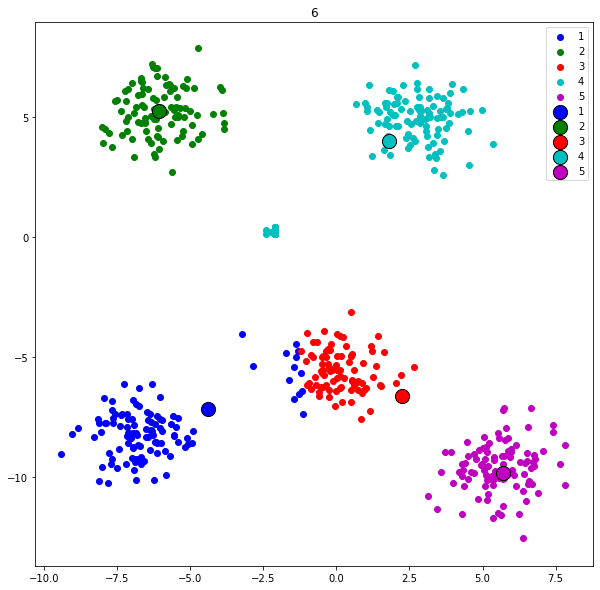

Loss value is  0.6367304500105146


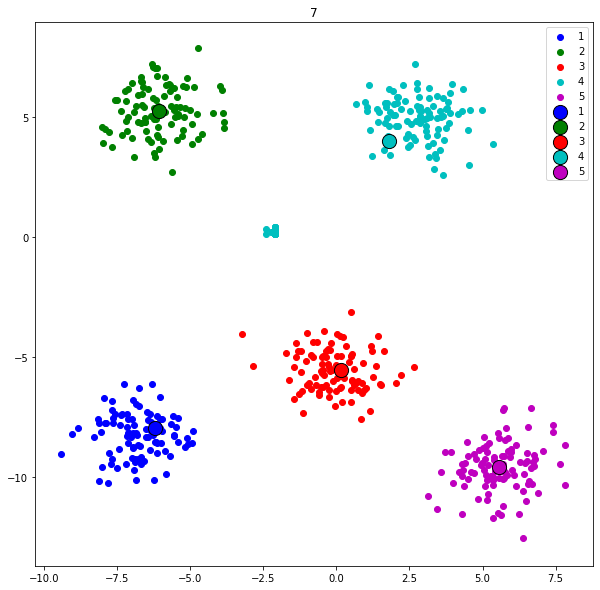

Loss value is  2.5928660278995768


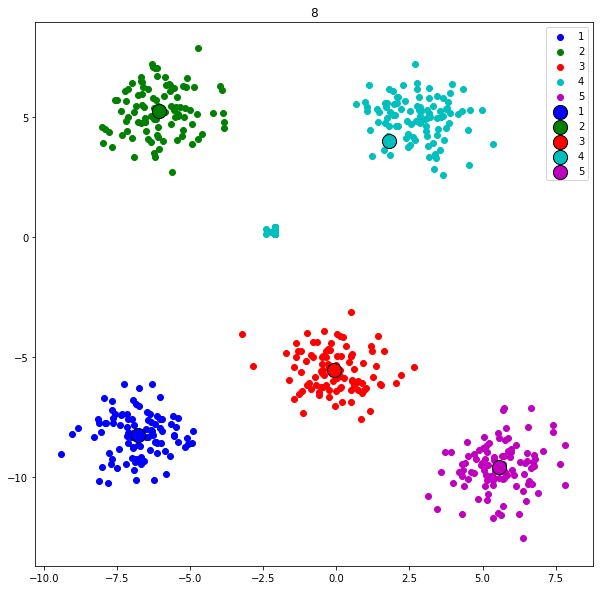

Loss value is  0.9014900936274373


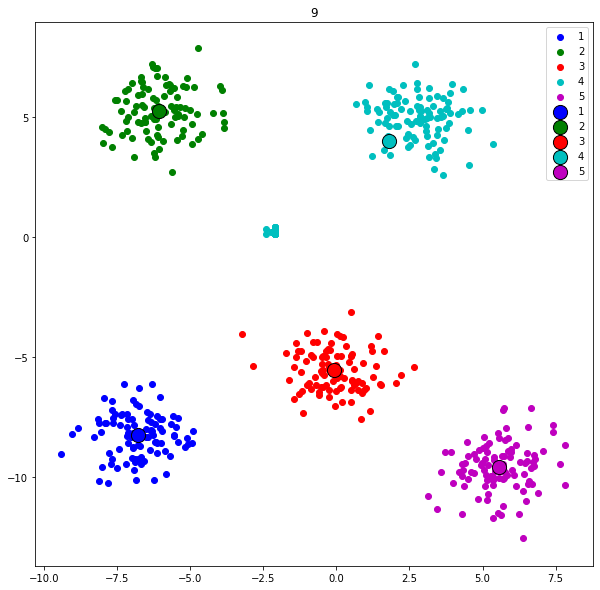

In [1041]:
# k =5

k_5_mean = iteration_fit(X,20,5,True)

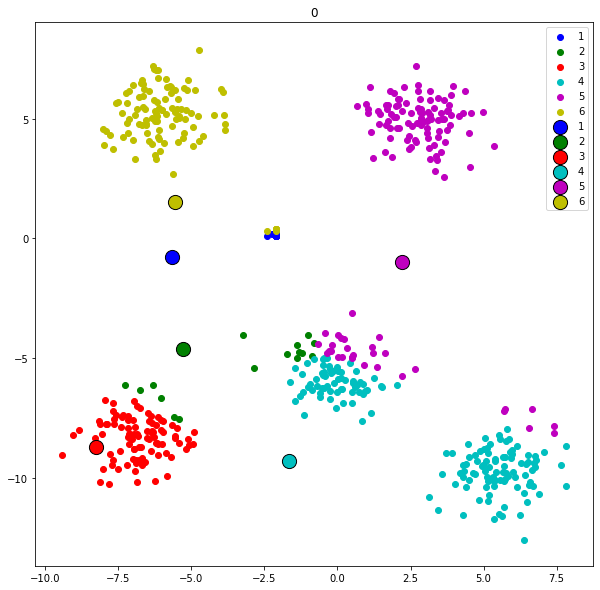

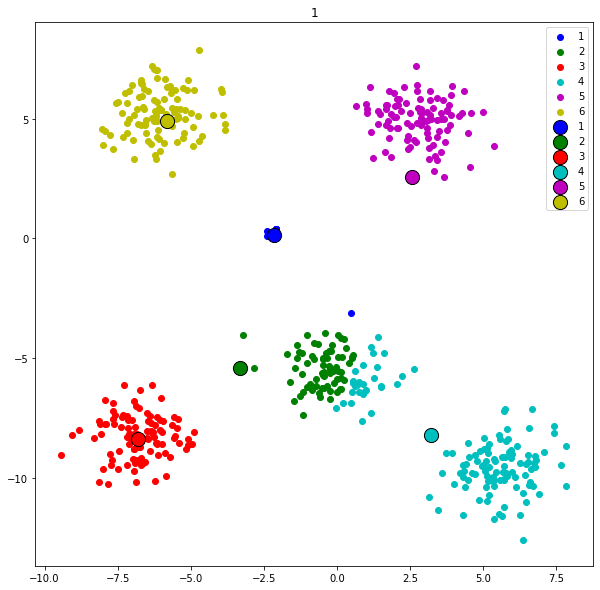

Loss value is  4.407586863248941


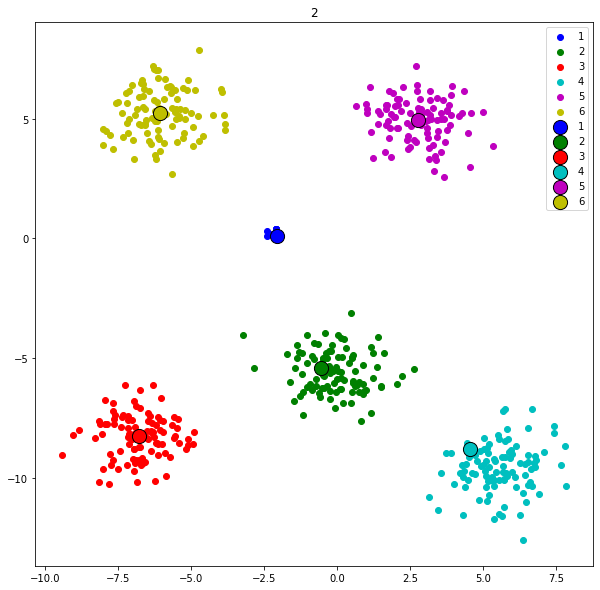

Loss value is  0.03371746661965776


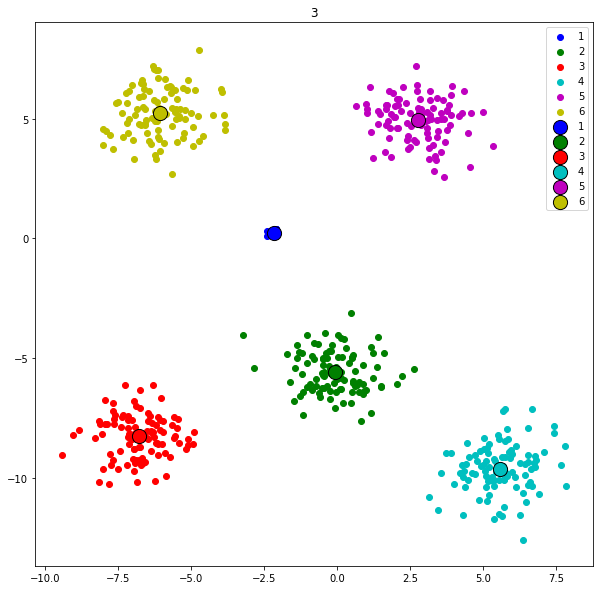

Loss value is  0.02717142226923097


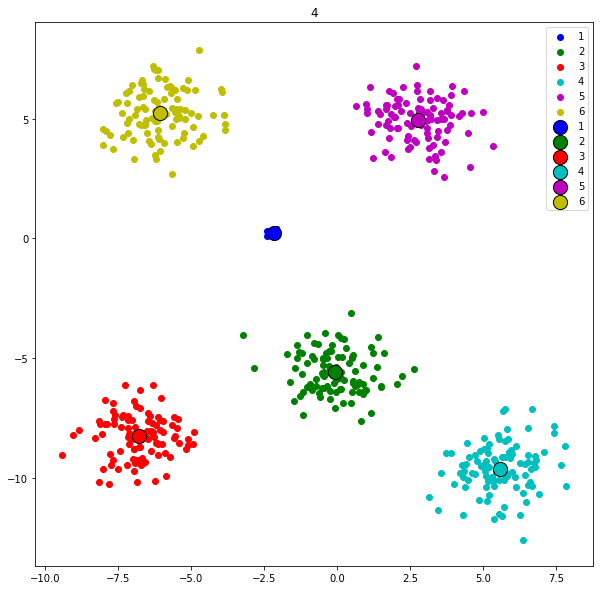

In [1042]:
# k =6

k_6_mean = iteration_fit(X,20,6,True)

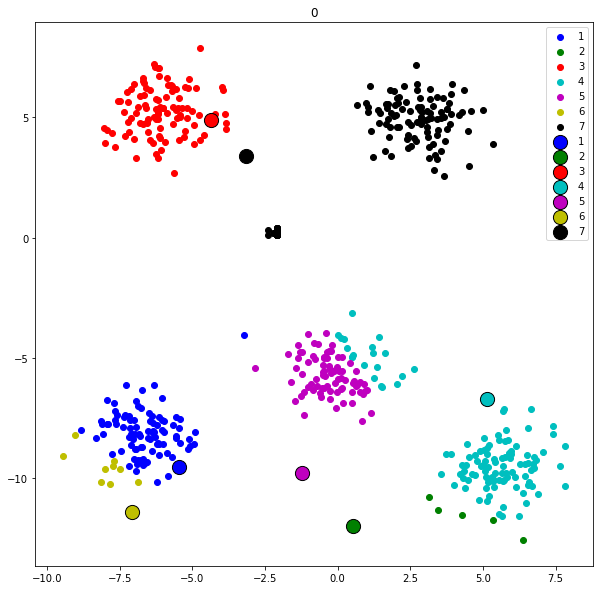

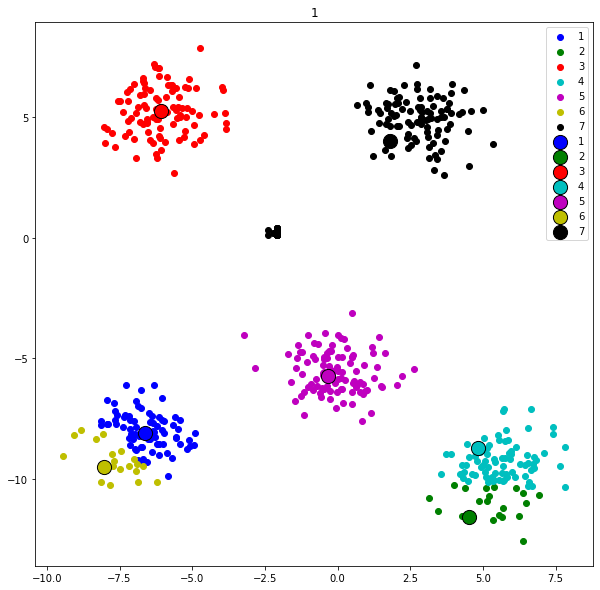

Loss value is  0.26657452214131805


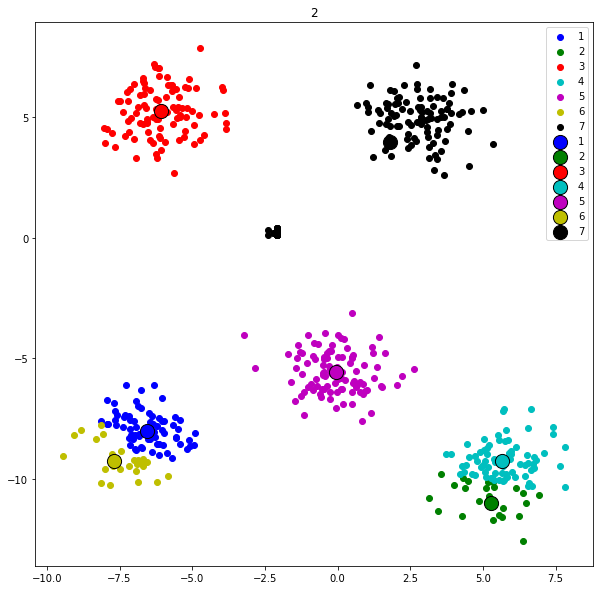

Loss value is  0.1453989558750033


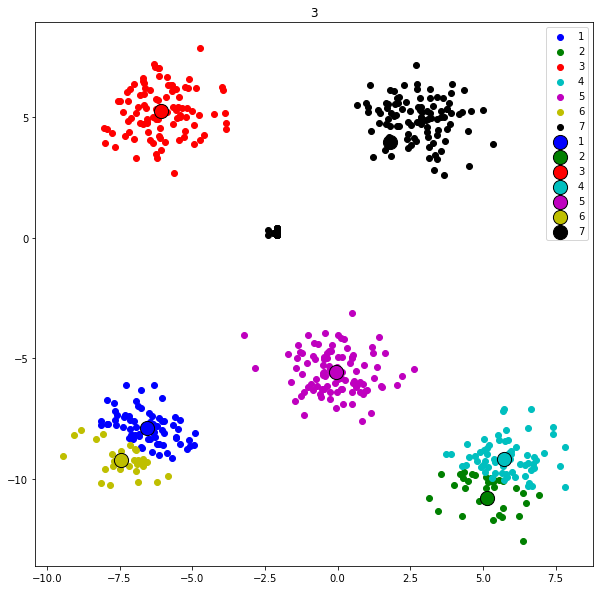

Loss value is  0.13032790960444984


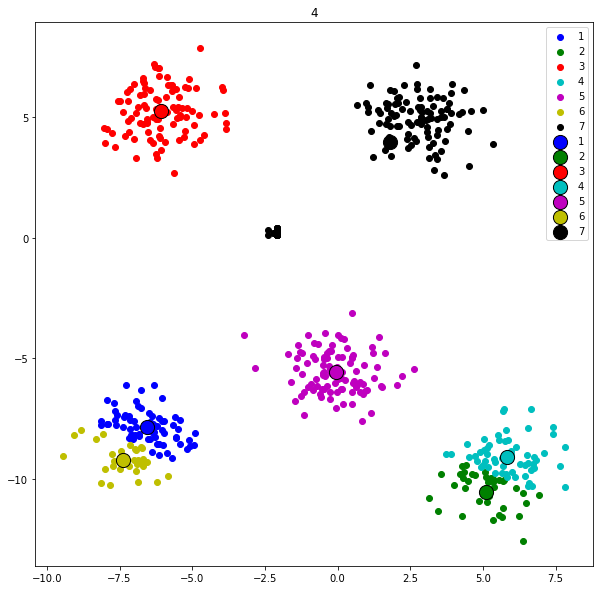

Loss value is  0.03414320099942181


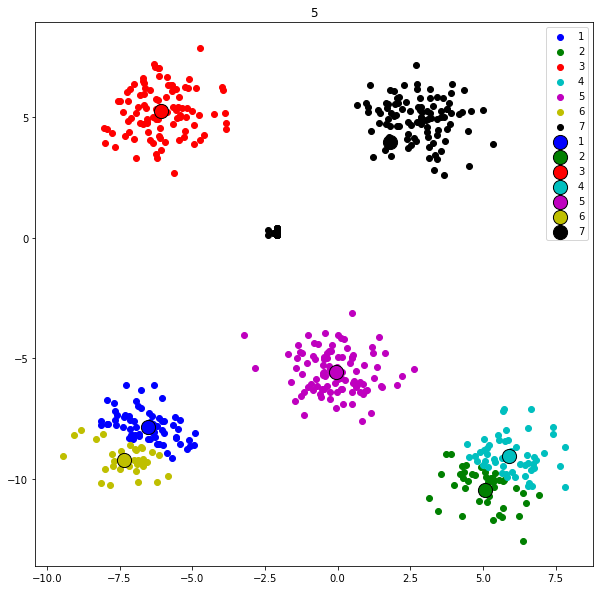

Loss value is  0.03021046250663506


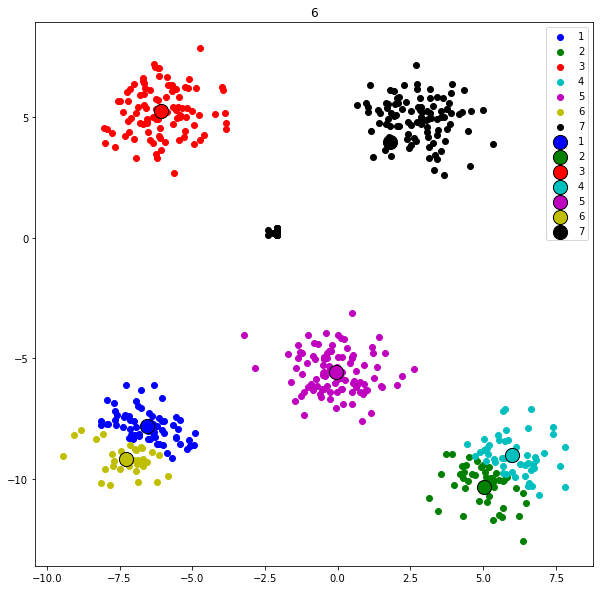

Loss value is  0.024815559074194304


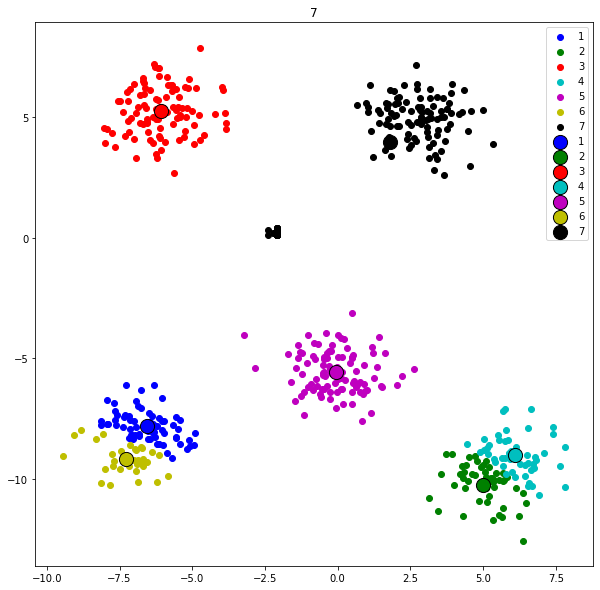

Loss value is  0.06357618660985054


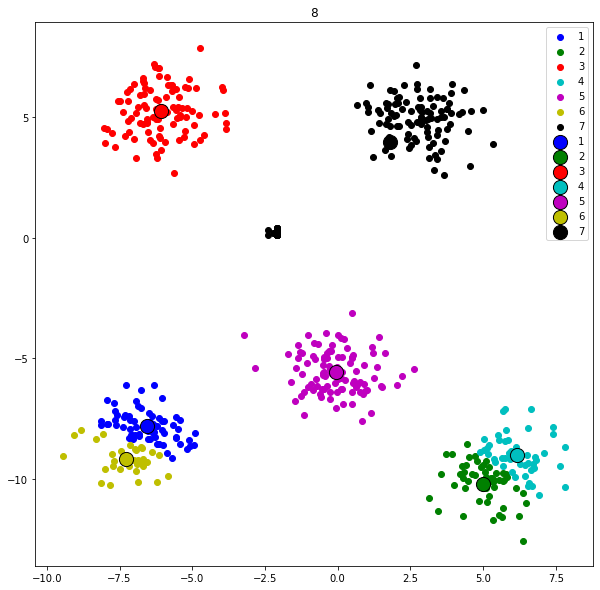

Loss value is  0.062299353737743424


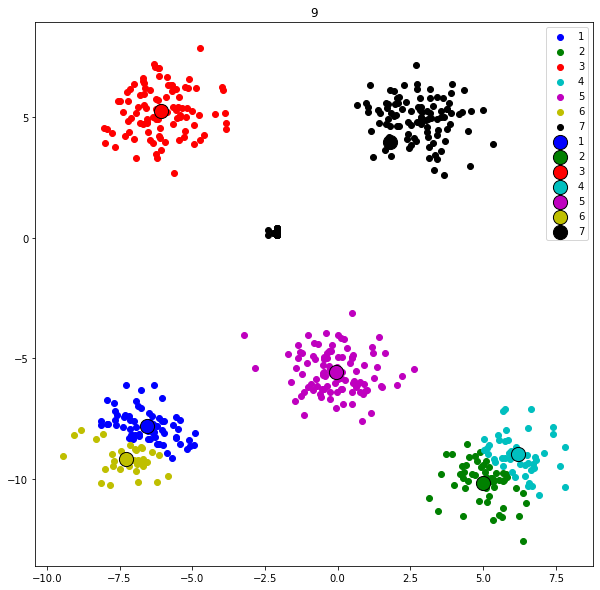

Loss value is  0.04307597496115445


In [1045]:
# k =7

k_7_mean = iteration_fit(X,10,7,True)

<h3 style="color:rgb(208,90,80)">Question 1a:</h3>

Your answer here.

hat do you observe?
How does the final loss change using different  𝑘 ? Why?
Do you get the same results if you run again? Why?

Based on the results from the experiment, the selection for clustering numbers is the major factor in the outcome from the K-mean method. In other words, it is an essential decision to select or find the best clustering number to obtain a better outcome with the K-mean method. As well, optimized k numbers could be a major reason for faster convergence of the K-mean clustering result which is beneficial for less computation time and resources. Since different initialization_center (or random initialization) are drawn, the results of every single run are not the same.





<h3 style="color:rgb(0,120,170)">Task 1b:</h3>

For $k=5$, plot cluster assignments and loss value after each iteration.

Question:
* What do you observe?


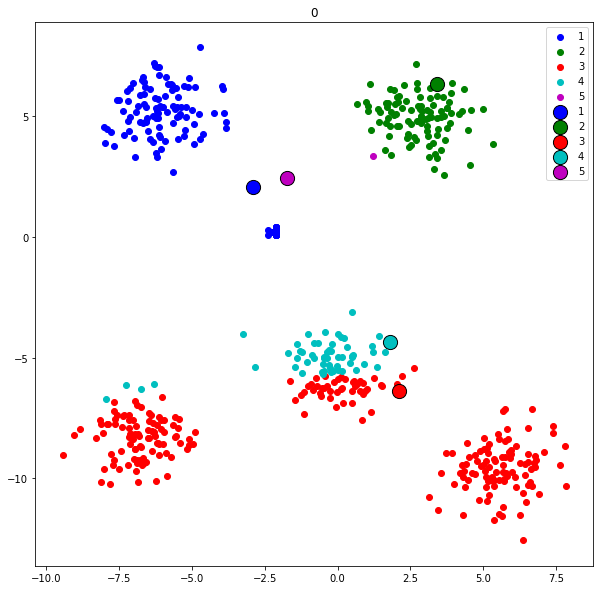

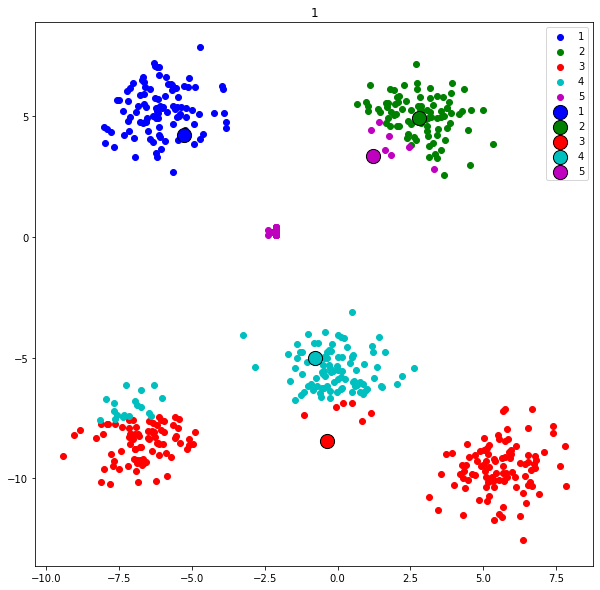

Loss value is  0.20799265707960135


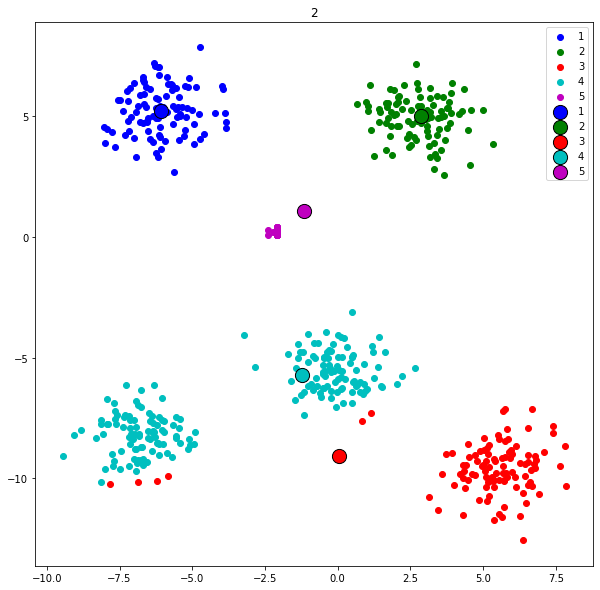

Loss value is  0.22054473758000004


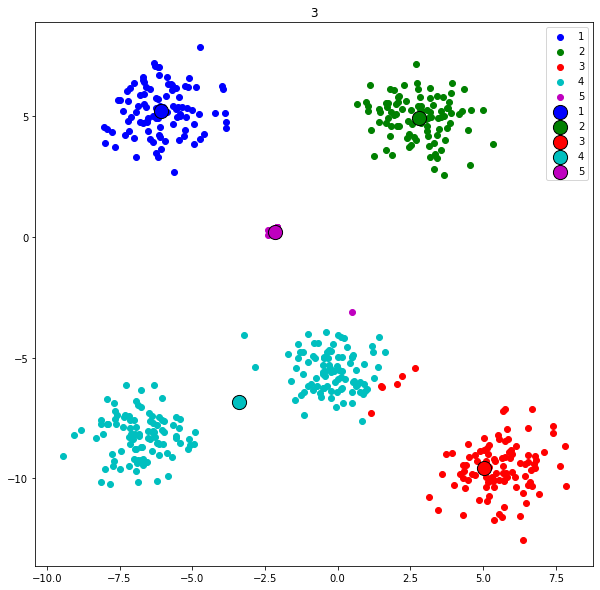

Loss value is  0.1806836525443476


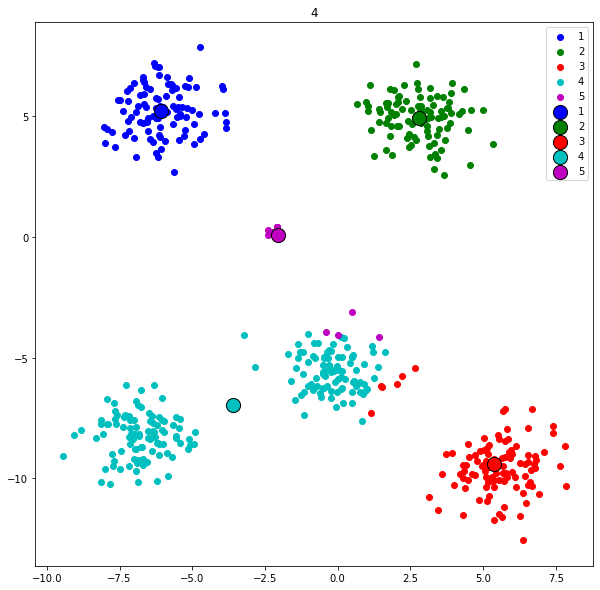

Loss value is  0.5115392997358486


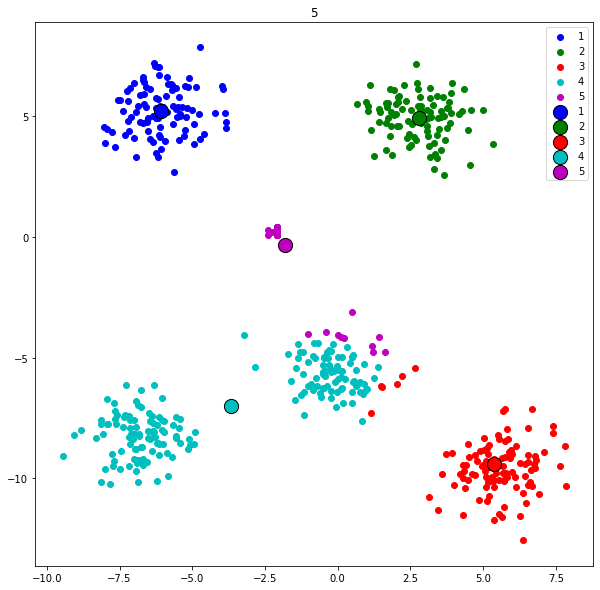

Loss value is  0.10853364042305635


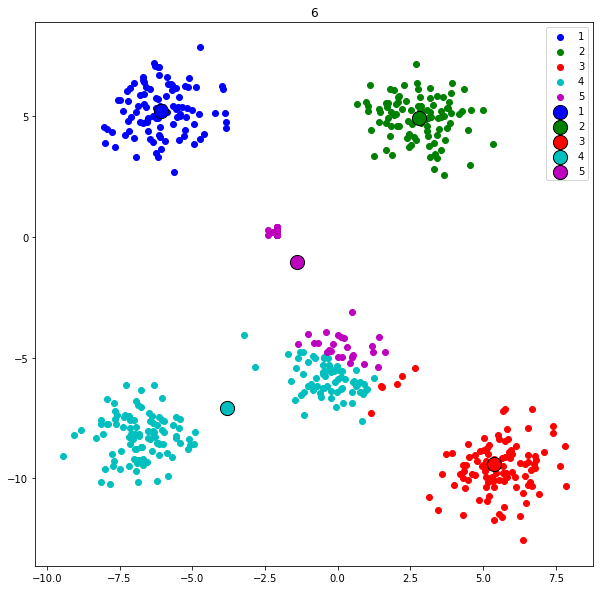

Loss value is  0.22265215877989197


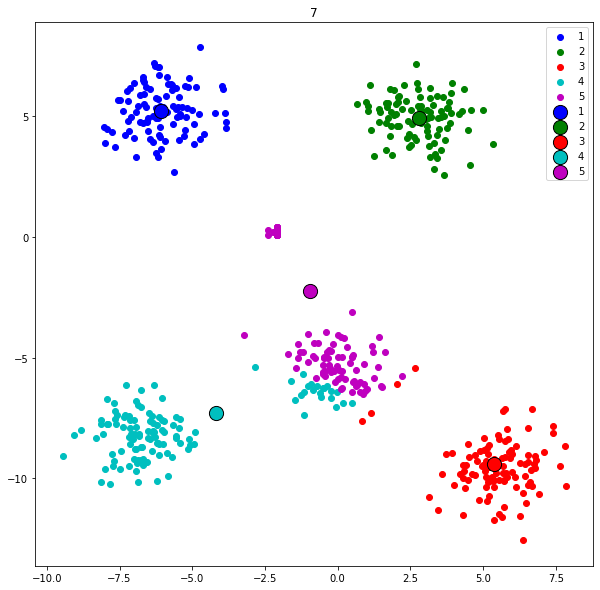

Loss value is  0.5848054922062209


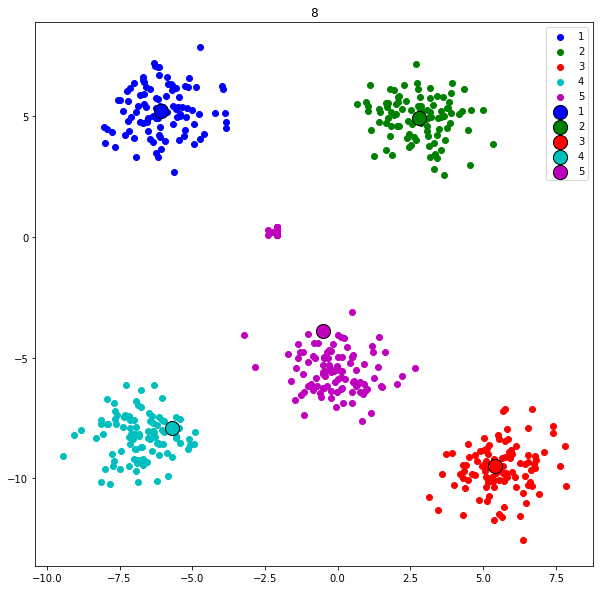

Loss value is  0.019255064264514843


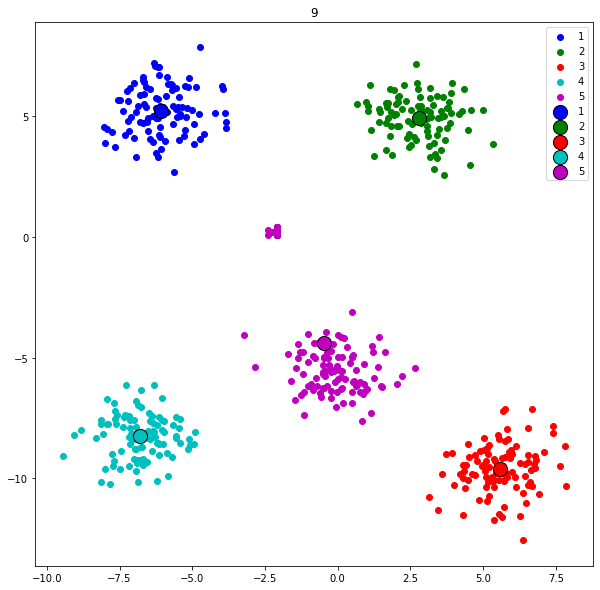

Loss value is  0.03429533351923286


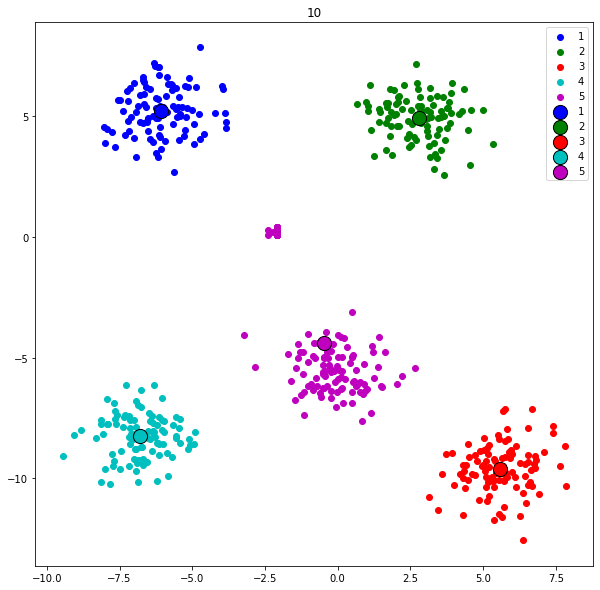

In [1046]:
# Begin your code

k_5_loss = iteration_fit(X,20,5,True)

# End your code

<h3 style="color:rgb(208,90,80)">Question 1b:</h3>

Your answer here.

Based on the results of the experiment, the number of clustering (5) is an appropriate selection for the clustering number with the K-mean method in this dataset. The final converged clustering plot represents an outstanding performance which is meaning that the dataset has been classified and clustered well. As well, the amount of computation time is not too long compared to others because it has a relatively less number of iteration to converge for the clusterings. 

<h3 style="color:rgb(0,120,170)">Task 1c:</h3>
 

This task will show how two different methods of computing the center (mean and median) affect the loss during iterations. To that end, run the algorithm and store the evolution of the loss per iteration for both methods.

Because the $k$-means algorithm is very sensitive to the initialization of the centers, repeat the process 100 times (100 trials) -- 1000 if you have the computing power --, and compute the loss average over all trials for each iteration and each method. To take into account that each trial might need a different number of iterations to converge. In such a case, pad the sequence with the converged value (the last value).

Plot the average loss versus iteration number for both the mean and the median method, using $k$ = 2, 5 and 8.

Question:
* What do you observe?



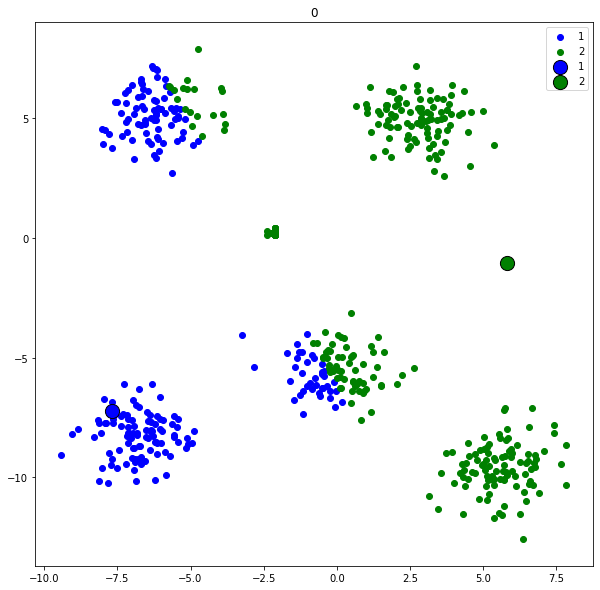

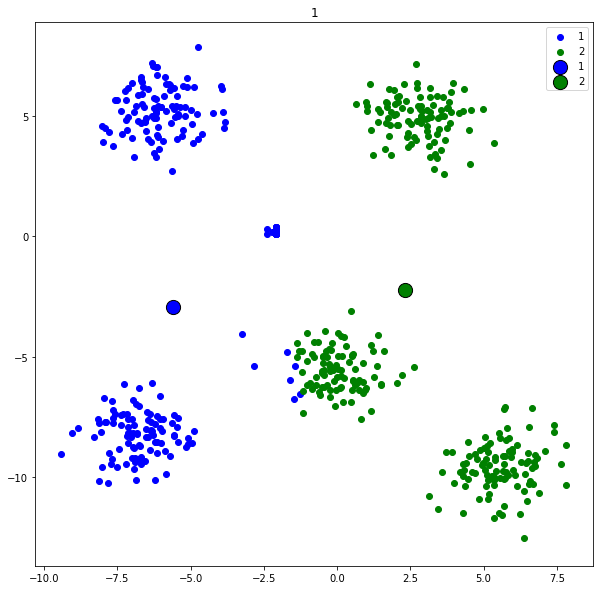

Loss value is  6.389656765319059


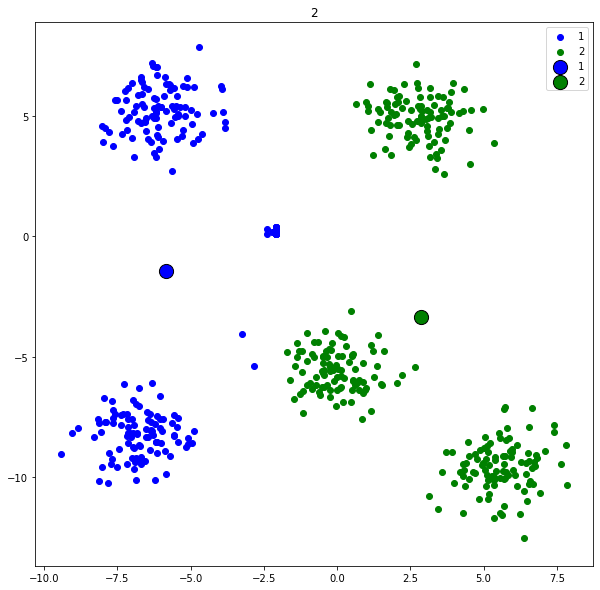

Loss value is  1.252969810614959


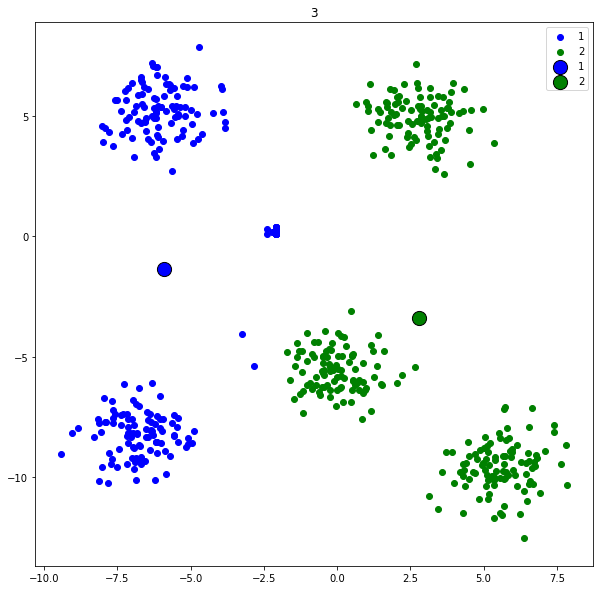

Loss value is  0.002895694791127834


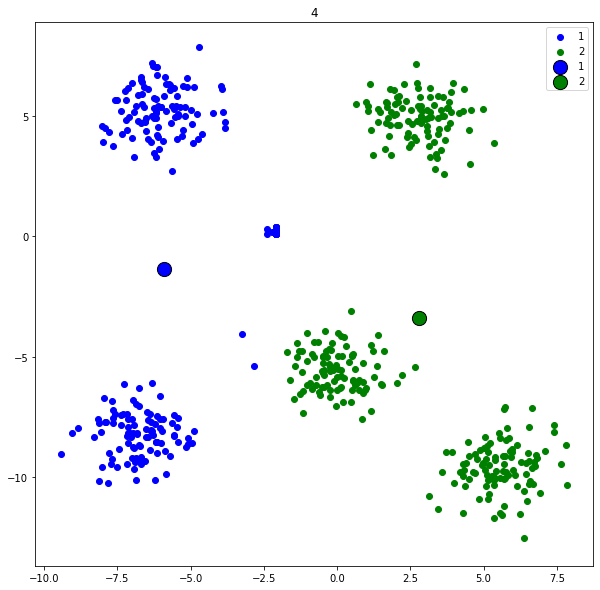

In [1131]:
k_2_mean = iteration_fit(X,15,2,True)

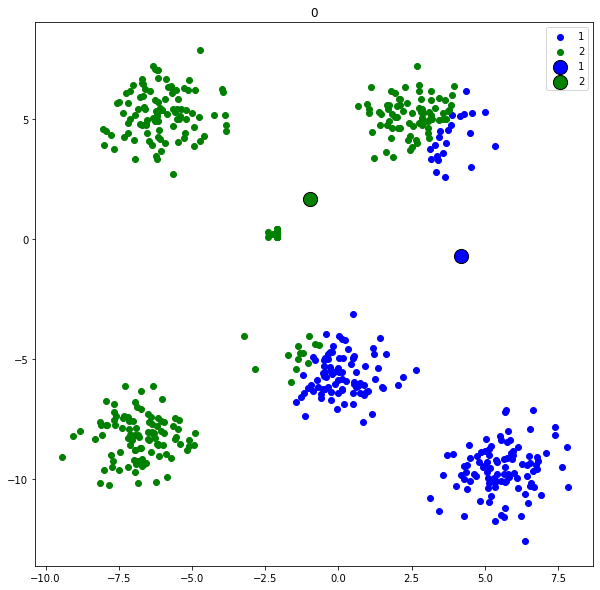

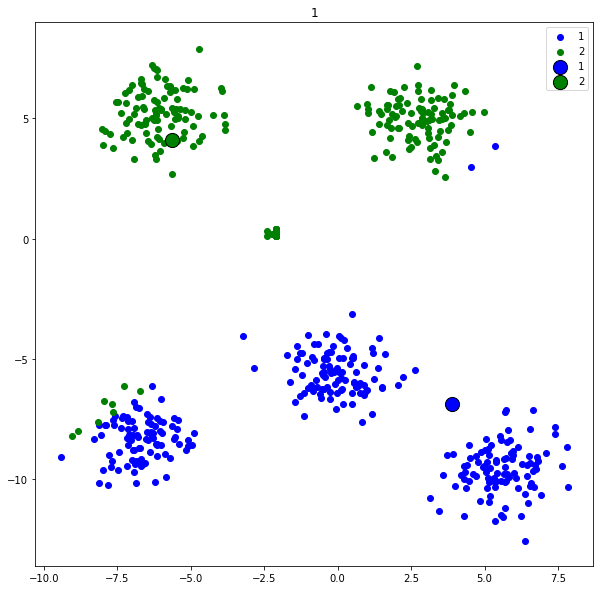

Loss value is  6.4764055631730635


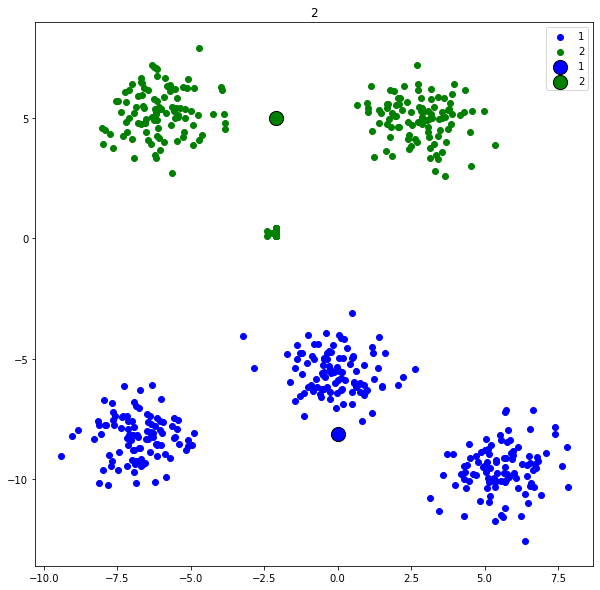

Loss value is  5.136105586935001


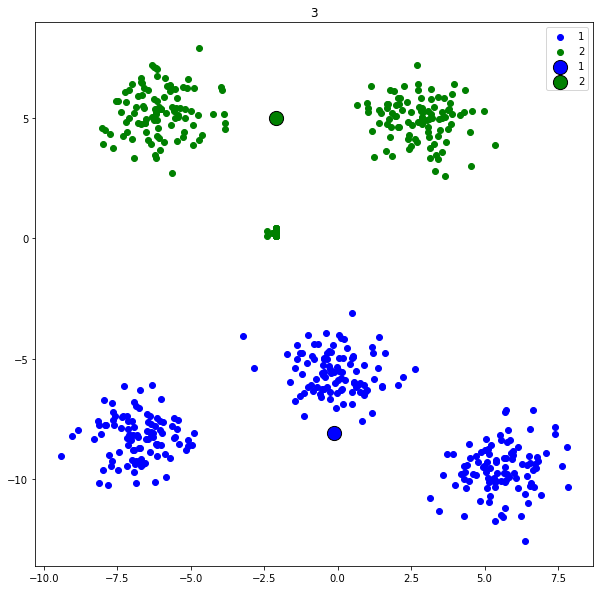

Loss value is  0.09033701256499779


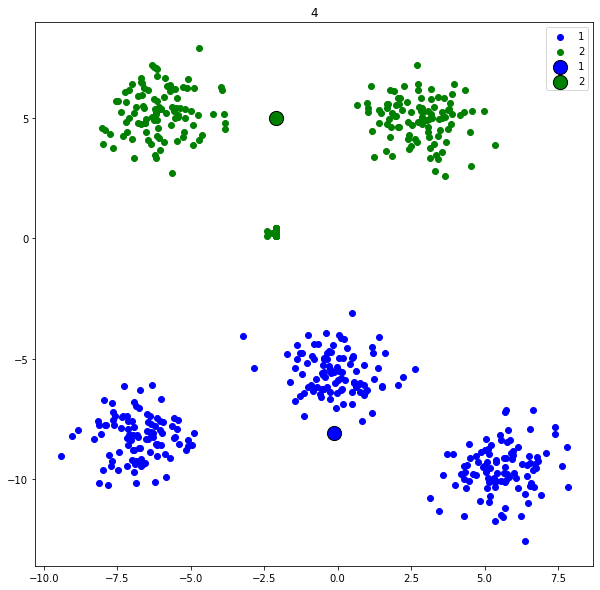

In [1132]:
k_2_median = iteration_fit(X,15,2,False)   # set mean_method = False for Median 

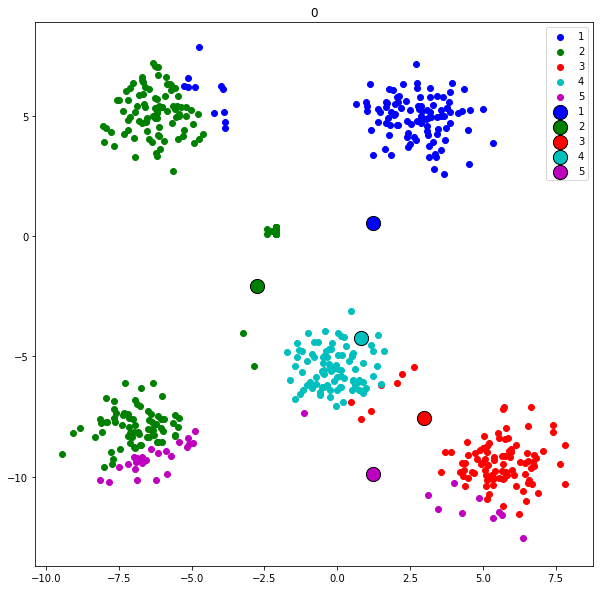

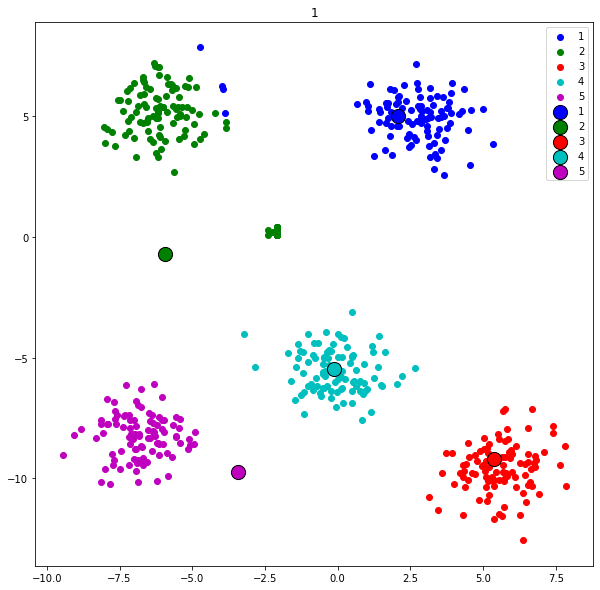

Loss value is  5.3046090397333385


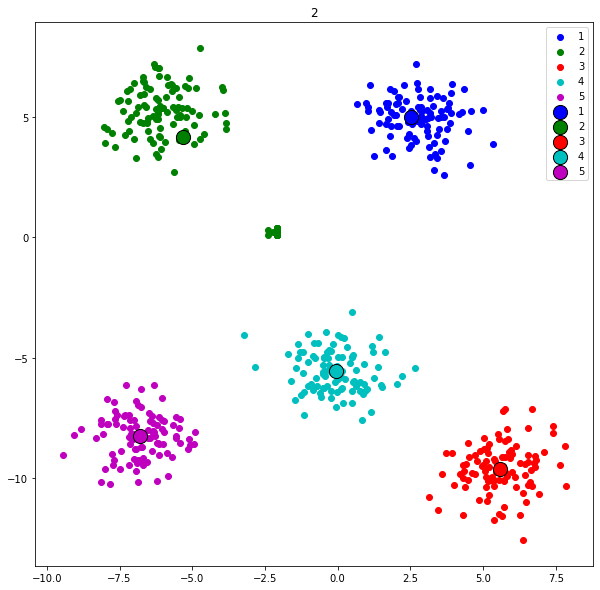

Loss value is  0.40673964281722164


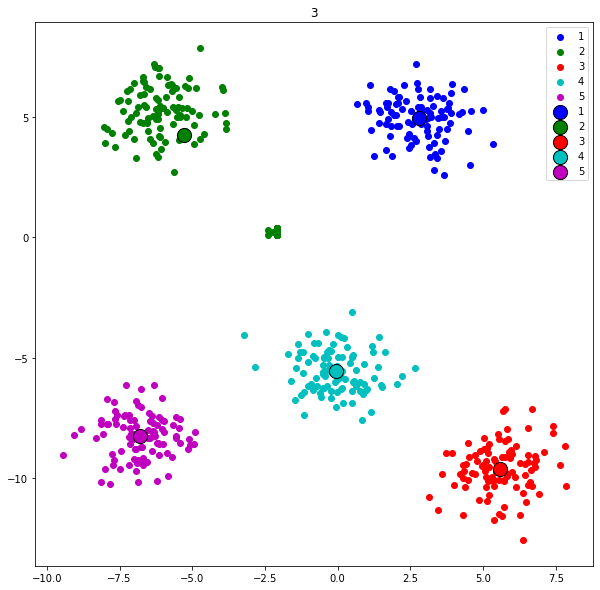

Loss value is  0.21139443958692405


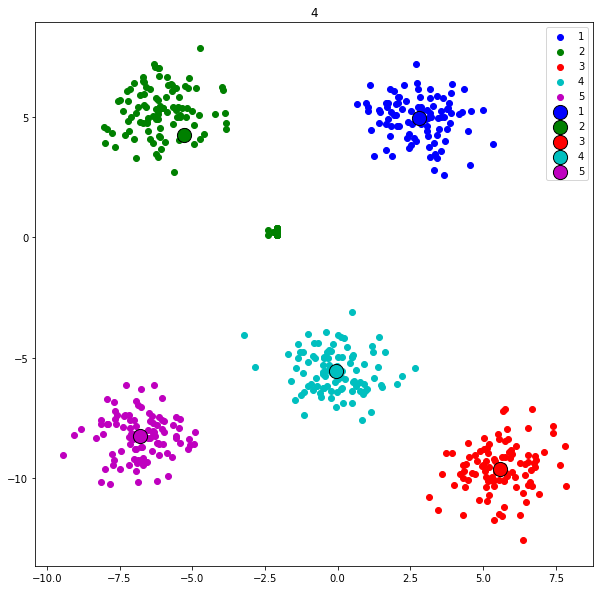

In [1133]:
k_5_mean = iteration_fit(X,10,5,True)

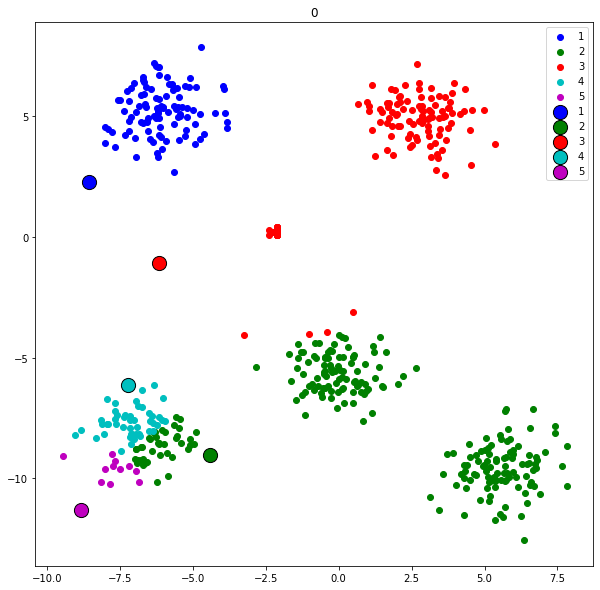

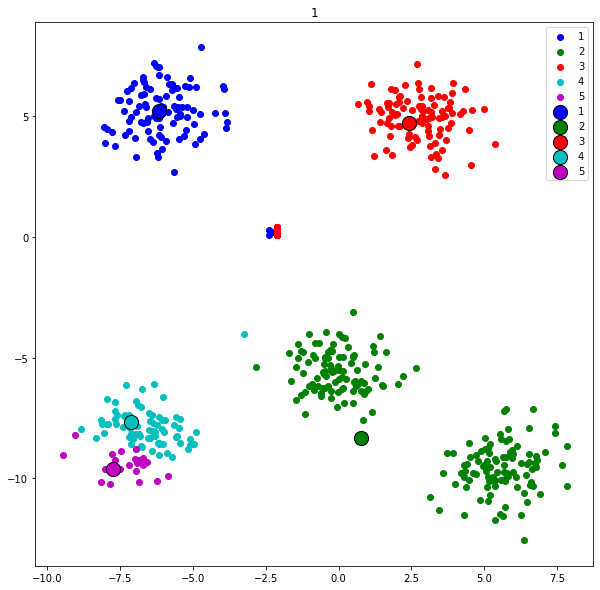

Loss value is  5.32521144197663


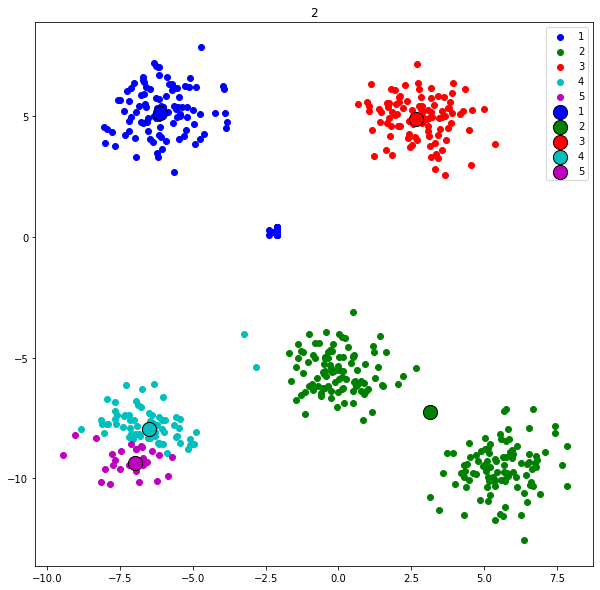

Loss value is  0.03447525500000026


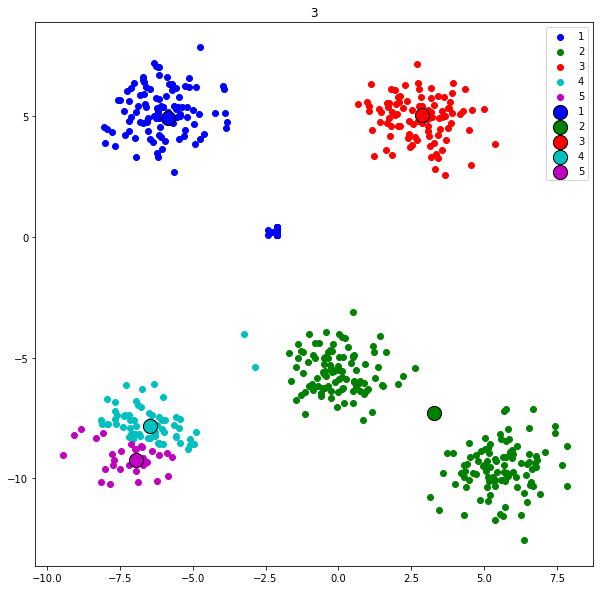

Loss value is  0.06292873999999937


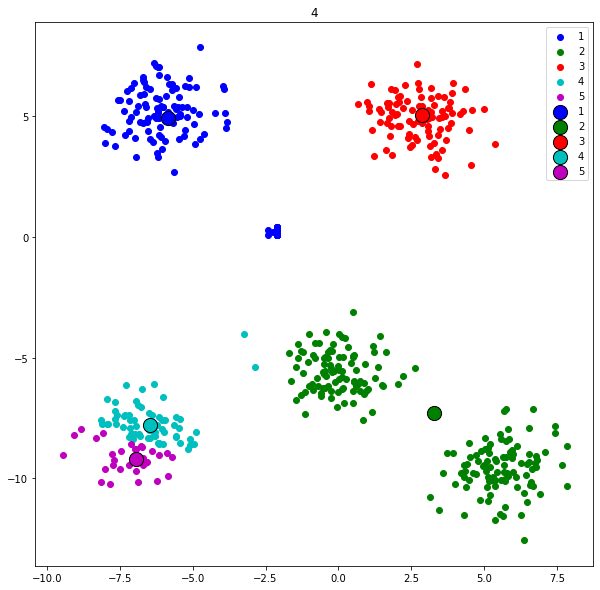

Loss value is  0.05212717499999986


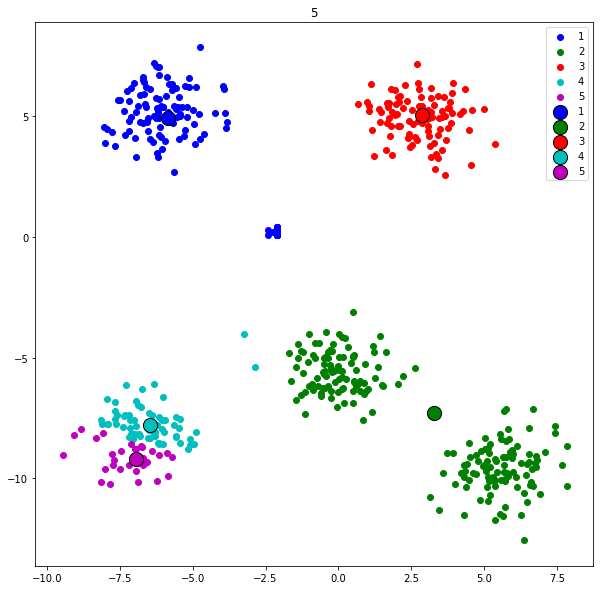

In [1134]:
k_5_median = iteration_fit(X,10,5,False)

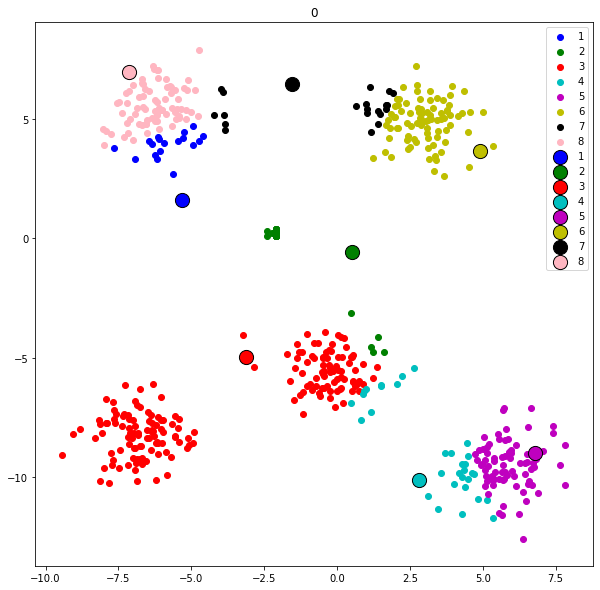

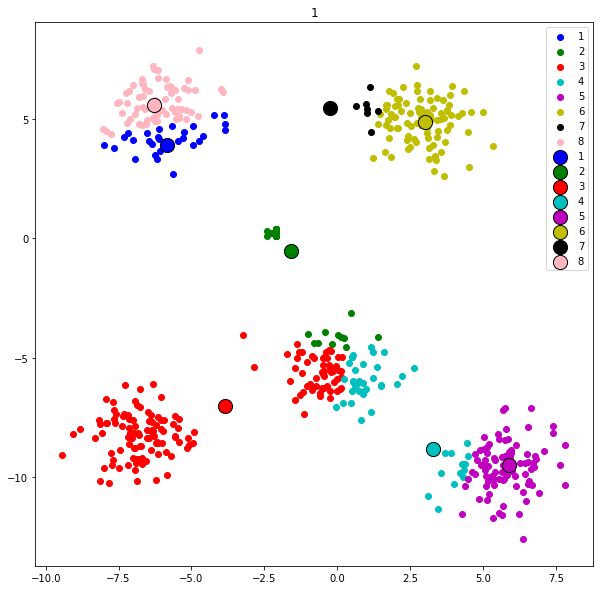

Loss value is  1.760536781184495


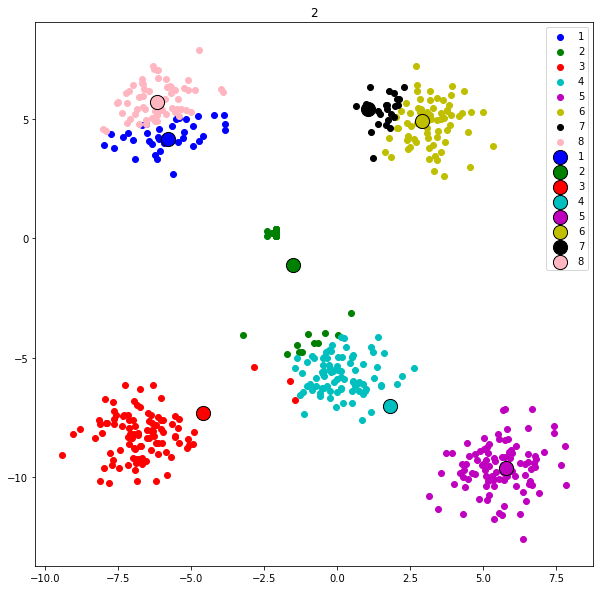

Loss value is  0.26187973867815995


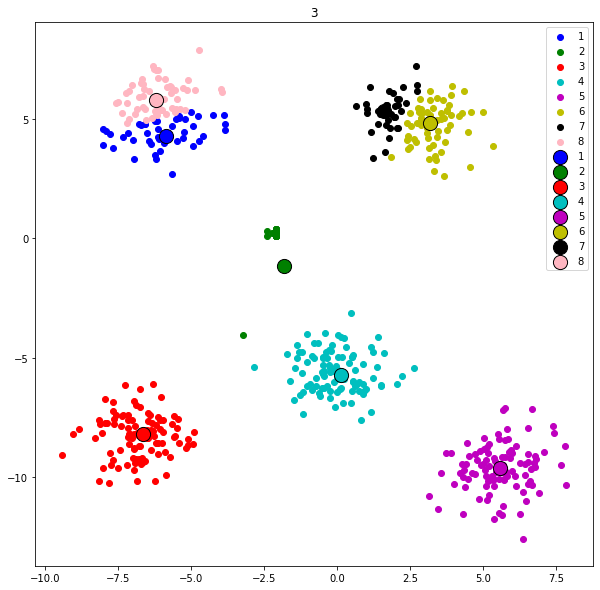

Loss value is  0.10186761521072718


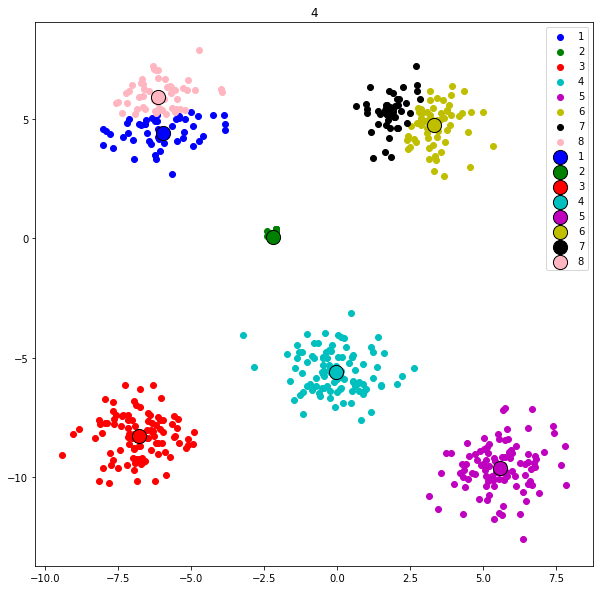

Loss value is  0.016667547146464123


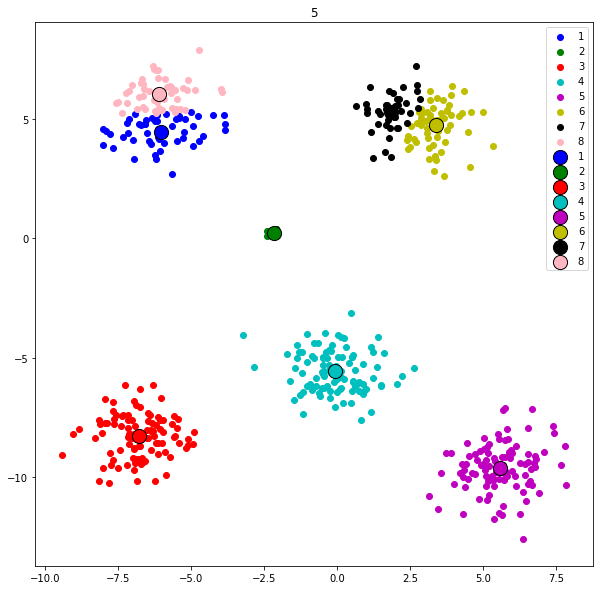

Loss value is  0.010625293511130174


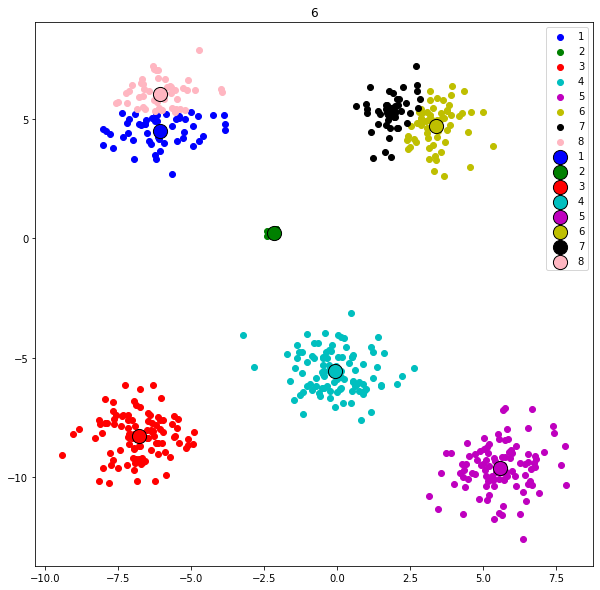

Loss value is  0.015388546474588871


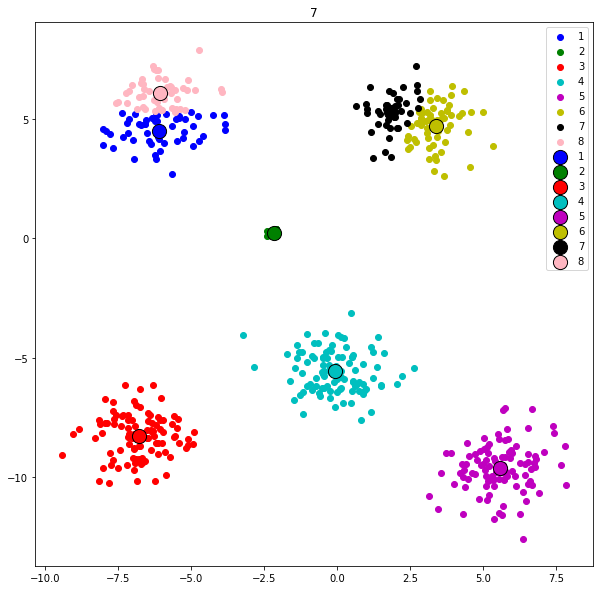

Loss value is  0.001452635985941697


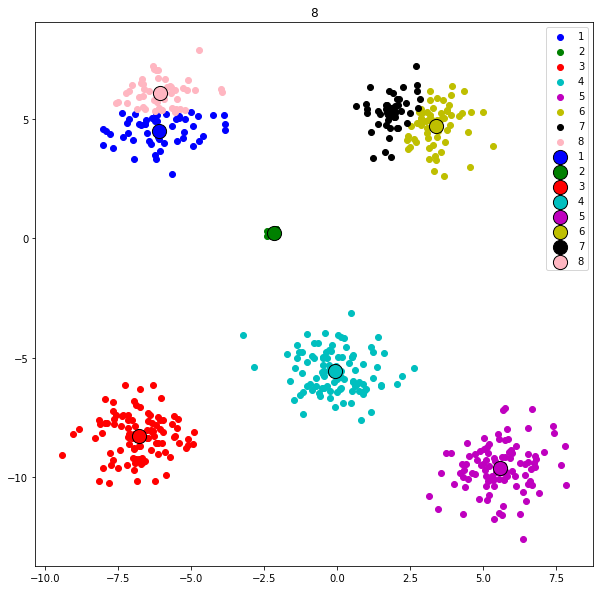

In [1135]:
k_8_mean = iteration_fit(X,10,8,True)

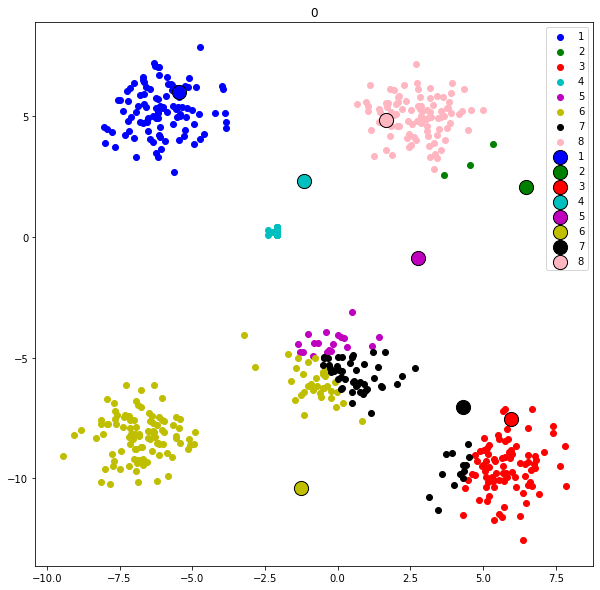

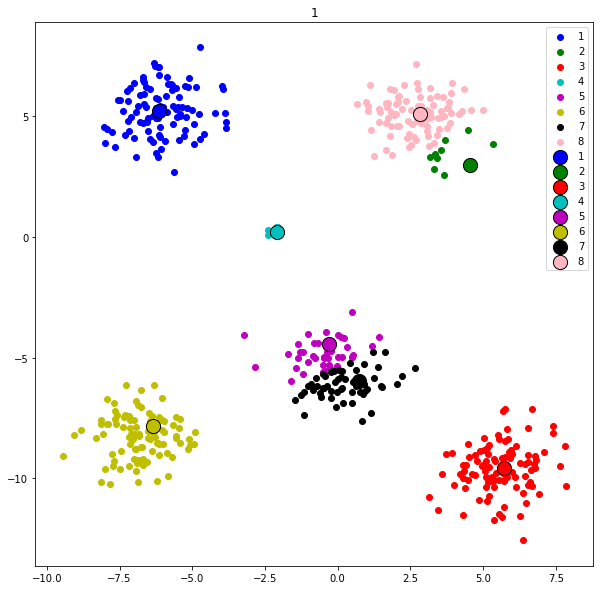

Loss value is  1.5061896110485309


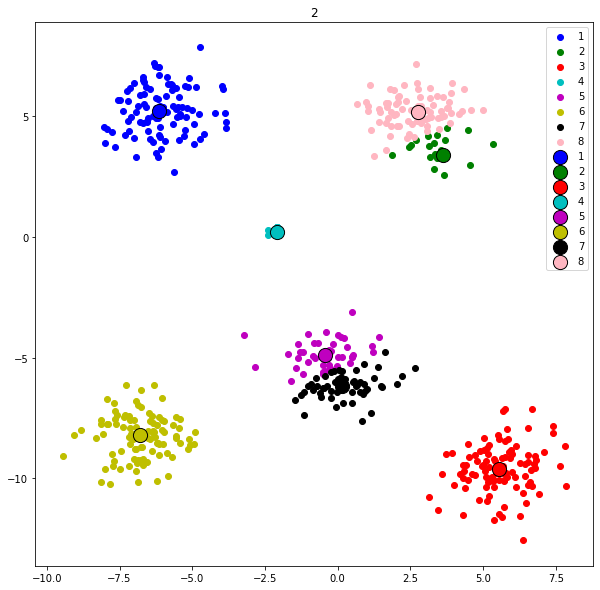

Loss value is  0.5429310199999997


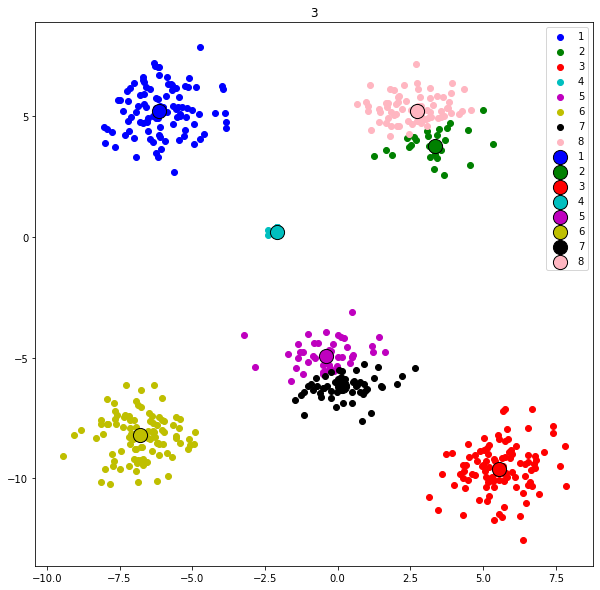

Loss value is  0.13166504000000012


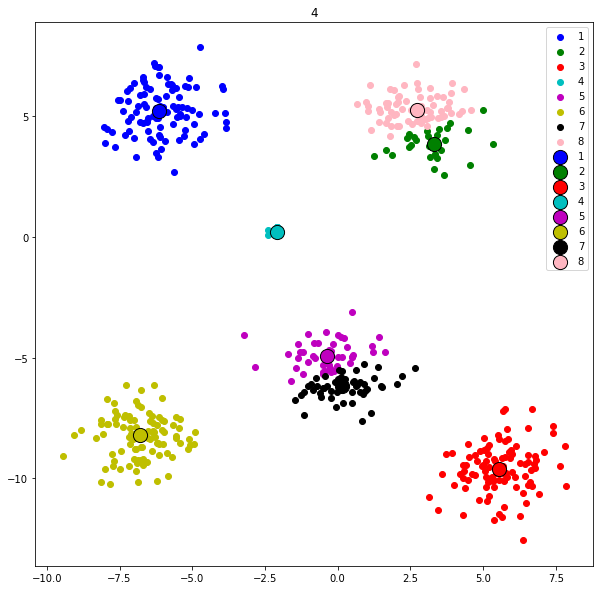

Loss value is  0.0820909900000002


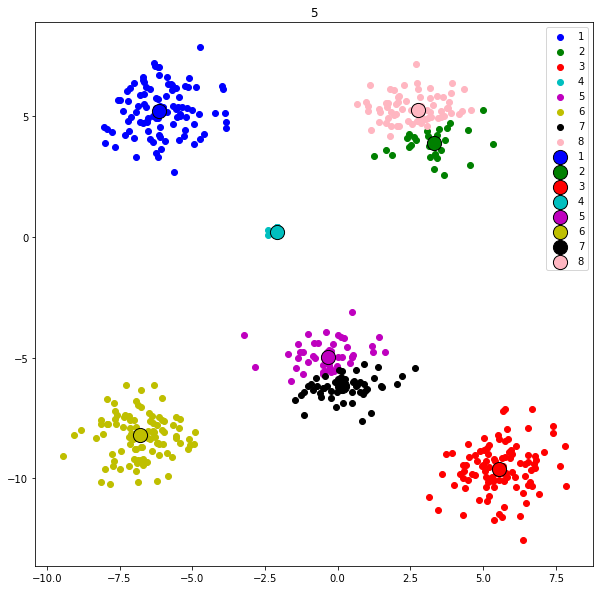

Loss value is  0.0007733050000000574


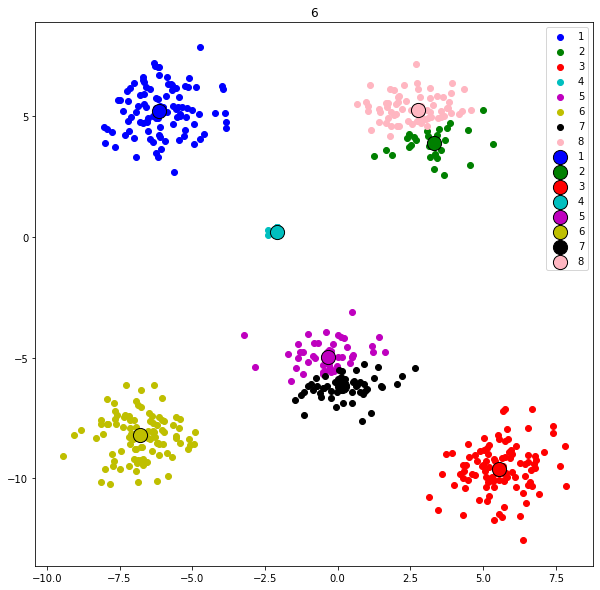

In [1130]:
k_8_median = iteration_fit(X,10,8,False)

<h3 style="color:rgb(208,90,80)">Question 1c:</h3>

Your answer here.

Based on the results of the experiment, it does not represent a significant difference between two centroid computation methods for every k numbers. In this experiment, the first random center position is the major impact to the final outcomes and computation time (or iteration number to converge designated number of clusterings)

<h3 style="color:rgb(0,120,170)">Task 2 (40 points):</h3> 

Use the data given in `cluster1.csv`, `cluster2.csv`, `cluster3.csv` and `cluster4.csv` to compare affinity propagation clustering with $k$-means clustering. Omit the third column of each data set since it contains the labels. Use $k = 2,3,4$ for $k$-means and plot your results. 

For affinity propagation you can use `AffinityPropagation` from `sklearn.cluster`. Use the default method ``affinity = euclidean`` (note that this is the negative squared Euclidean distance). For the preference, try the negative squared minimum, negative squared median and negative squared maximum of the similarity matrix (which is computed using the negative squared Euclidean distance).

For the $k$-means algorithm you can either use your own implementation from Task 1 or use `KMeans` from `sklearn.cluster`. In any case, keep using the (standard) Euclidean distance.

Use the provided labels to determine which algorithm and which number of clusters give better results on a specific data set and explain why one algorithm might have an advantage over the other one.

Questions:
* Which method is faster?
* Which method performs best in each dataset?
* Is any dataset not "solved" by the $k$-means or Affinity Propagation? Why? Which parameters could be modified for improvement?

In [1047]:
# Begin your code (multiple cells)

In [1048]:
from sklearn.cluster import AffinityPropagation 
from sklearn.cluster import KMeans

In [1049]:
data_1 = np.loadtxt(open('cluster1.csv', 'r'), delimiter=',', skiprows=1)
data_2 = np.loadtxt(open('cluster2.csv', 'r'), delimiter=',', skiprows=1)
data_3 = np.loadtxt(open('cluster3.csv', 'r'), delimiter=',', skiprows=1)
data_4 = np.loadtxt(open('cluster4.csv', 'r'), delimiter=',', skiprows=1)


In [1050]:
X_1 = data_1[:, :2]
X_2 = data_2[:, :2]
X_3 = data_3[:, :2]
X_4 = data_4[:, :2]

In [1051]:
y_1 = data_1[:, -1] # Target values (labels)
y_2 = data_2[:, -1] # Target values (labels)
y_3 = data_3[:, -1] # Target values (labels)
y_4 = data_4[:, -1] # Target values (labels)


In [1052]:
## AffinityPropagation ##

In [1053]:
## cluster1.csv ##

af_data_1 = AffinityPropagation(affinity = "euclidean", verbose= True).fit(X_1)

Did not converge


C:\Users\J. Park\Anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:226: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)


In [1054]:
## define af_data_1 similarity matrix which is computed by the euclidean distance

af_data_1_mat = af_data_1.affinity_matrix_

In [1055]:
af_data_1_mat_min = np.min(af_data_1_mat)

af_data_1_mat_median = np.median(af_data_1_mat)

af_data_1_mat_max = np.max(af_data_1_mat)

In [1056]:
af_data_1_min = AffinityPropagation(affinity = "euclidean", verbose= True, preference = af_data_1_mat_min).fit(X_1)

Did not converge


C:\Users\J. Park\Anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:226: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)


In [1057]:
af_data_1_median = AffinityPropagation(affinity = "euclidean", verbose= True, preference = af_data_1_mat_median).fit(X_1)

Did not converge


C:\Users\J. Park\Anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:226: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)


In [1058]:
af_data_1_max = AffinityPropagation(affinity = "euclidean", verbose= True, preference = af_data_1_mat_max).fit(X_1)

Converged after 15 iterations.


In [1059]:
data_1_min_cluster_centers_indices_ = af_data_1_min.cluster_centers_indices_

no_clusters = len(data_1_min_cluster_centers_indices_)

print('Estimated number of clusters: %d' % no_clusters)

Estimated number of clusters: 0


In [1060]:
data_1_median_cluster_centers_indices_ = af_data_1_median.cluster_centers_indices_

no_clusters = len(data_1_median_cluster_centers_indices_ )

print('Estimated number of clusters: %d' % no_clusters)

Estimated number of clusters: 0


In [1061]:
data_1_max_cluster_centers_indices_ = af_data_1_max.cluster_centers_indices_

no_clusters = len(data_1_max_cluster_centers_indices_ )

print('Estimated number of clusters: %d' % no_clusters)

Estimated number of clusters: 1499


In [1062]:
## cluster2.csv ##

af_data_2 = AffinityPropagation(affinity = "euclidean", verbose= True).fit(X_2)

Converged after 25 iterations.


In [1063]:
## define af_data_2 similarity matrix which is computed by the euclidean distance

af_data_2_mat = af_data_2.affinity_matrix_

In [1064]:
af_data_2_mat_min = np.min(af_data_2_mat)

af_data_2_mat_median = np.median(af_data_2_mat)

af_data_2_mat_max = np.max(af_data_2_mat)

In [1065]:
af_data_2_min = AffinityPropagation(affinity = "euclidean", verbose= True, preference = af_data_2_mat_min).fit(X_2)

Converged after 36 iterations.


In [1066]:
af_data_2_median = AffinityPropagation(affinity = "euclidean", verbose= True, preference = af_data_2_mat_median).fit(X_2)

Converged after 25 iterations.


In [1067]:
af_data_2_max = AffinityPropagation(affinity = "euclidean", verbose= True, preference = af_data_2_mat_max).fit(X_2)

Converged after 15 iterations.


In [1068]:
data_2_min_cluster_centers_indices_ = af_data_2_min.cluster_centers_indices_

no_clusters = len(data_2_min_cluster_centers_indices_ )

print('Estimated number of clusters: %d' % no_clusters)

Estimated number of clusters: 3


In [1069]:
af_data_2_min_label = af_data_2_min.labels_

In [1070]:
data_2_median_cluster_centers_indices_ = af_data_2_median.cluster_centers_indices_

no_clusters = len(data_2_median_cluster_centers_indices_)

print('Estimated number of clusters: %d' % no_clusters)

Estimated number of clusters: 10


In [1071]:
af_data_2_median_label = af_data_2_median.labels_

In [1072]:
data_2_max_cluster_centers_indices_ = af_data_2_max.cluster_centers_indices_

no_clusters = len(data_2_max_cluster_centers_indices_)

print('Estimated number of clusters: %d' % no_clusters)

Estimated number of clusters: 149


In [1073]:
af_data_2_max_label = af_data_2_max.labels_

In [1074]:
## cluster3.csv ##

af_data_3 = AffinityPropagation(affinity = "euclidean", verbose= True).fit(X_3)

Converged after 58 iterations.


In [1075]:
## define af_data_3 similarity matrix which is computed by the euclidean distance

af_data_3_mat = af_data_3.affinity_matrix_

In [1076]:
af_data_3_mat_min = np.min(af_data_3_mat)

af_data_3_mat_median = np.median(af_data_3_mat)

af_data_3_mat_max = np.max(af_data_3_mat)

In [1077]:
af_data_3_min = AffinityPropagation(affinity = "euclidean", verbose= True, preference = af_data_3_mat_min).fit(X_3)

Did not converge


C:\Users\J. Park\Anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:226: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)


In [1078]:
af_data_3_median = AffinityPropagation(affinity = "euclidean", verbose= True, preference = af_data_3_mat_median).fit(X_3)

Converged after 58 iterations.


In [1079]:
af_data_3_max = AffinityPropagation(affinity = "euclidean", verbose= True, preference = af_data_3_mat_max).fit(X_3)

Converged after 15 iterations.


In [1080]:
data_3_min_cluster_centers_indices_ = af_data_3_min.cluster_centers_indices_

no_clusters = len(data_3_min_cluster_centers_indices_)

print('Estimated number of clusters: %d' % no_clusters)

Estimated number of clusters: 0


In [1081]:
data_3_median_cluster_centers_indices_ = af_data_3_median.cluster_centers_indices_

no_clusters = len(data_3_median_cluster_centers_indices_)

print('Estimated number of clusters: %d' % no_clusters)

Estimated number of clusters: 12


In [1082]:
data_3_max_cluster_centers_indices_ = af_data_3_max.cluster_centers_indices_

no_clusters = len(data_3_max_cluster_centers_indices_)

print('Estimated number of clusters: %d' % no_clusters)

Estimated number of clusters: 499


In [1083]:
af_data_3_min_label = af_data_3_min.labels_
af_data_3_median_label = af_data_3_median.labels_
af_data_3_max_label = af_data_3_max.labels_

In [1084]:
## cluster4.csv ##


af_data_4 = AffinityPropagation(affinity = "euclidean", verbose= True).fit(X_4)

## define af_data_2 similarity matrix which is computed by the euclidean distance

af_data_4_mat = af_data_4.affinity_matrix_

af_data_4_mat_min = np.min(af_data_4_mat)

af_data_4_mat_median = np.median(af_data_4_mat)

af_data_4_mat_max = np.max(af_data_4_mat)


Converged after 38 iterations.


In [1085]:
af_data_4_min = AffinityPropagation(affinity = "euclidean", verbose= True, preference = af_data_4_mat_min).fit(X_4)


Converged after 124 iterations.


In [1086]:
af_data_4_median = AffinityPropagation(affinity = "euclidean", verbose= True, preference = af_data_4_mat_median).fit(X_4)


Converged after 38 iterations.


In [1087]:
af_data_4_max = AffinityPropagation(affinity = "euclidean", verbose= True, preference = af_data_4_mat_max).fit(X_4)

Converged after 15 iterations.


In [1088]:
data_4_min_cluster_centers_indices_ = af_data_4_min.cluster_centers_indices_

no_clusters = len(data_4_min_cluster_centers_indices_)

print('Estimated number of clusters: %d' % no_clusters)

Estimated number of clusters: 5


In [1089]:
data_4_median_cluster_centers_indices_ = af_data_4_median.cluster_centers_indices_

no_clusters = len(data_4_median_cluster_centers_indices_)

print('Estimated number of clusters: %d' % no_clusters)

Estimated number of clusters: 12


In [1090]:
data_4_max_cluster_centers_indices_ = af_data_4_max.cluster_centers_indices_

no_clusters = len(data_4_max_cluster_centers_indices_)

print('Estimated number of clusters: %d' % no_clusters)

Estimated number of clusters: 199


In [1091]:
af_data_4_min_label = af_data_4_min.labels_
af_data_4_median_label = af_data_4_median.labels_
af_data_4_max_label = af_data_4_max.labels_

In [1092]:
## K-mean Clustering ##

In [1093]:
## cluster_2.csv ###

## K-mean clustering with n_cluster = 2 ##

kmeans_2 = KMeans(n_clusters=2)
kmeans_2.fit(X_1)
labels_X_1_k_2 = kmeans_2.predict(X_1)
centroids_2 = kmeans_2.cluster_centers_

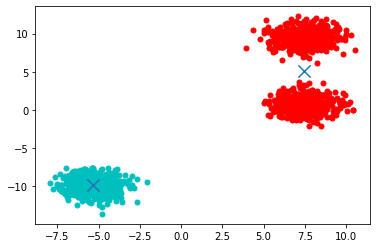

In [1094]:
colors = ["c.","r."]

for i in range(len(X_1)):
    #print("coordinate:",X_1[i], "label:", labels_X_1_k_2[i])
    plt.plot(X_1[i][0], X_1[i][1], colors[labels_X_1_k_2[i]], markersize = 10)


plt.scatter(centroids_2[:, 0],centroids_2[:, 1], marker = "x", s=150, linewidths = 5, zorder = 10)

plt.show()

In [1095]:
## k-mean clustering with n_clusters = 3  ##

kmeans_3 = KMeans(n_clusters=3)
kmeans_3.fit(X_1)
labels_X_1_k_3 = kmeans_3.predict(X_1)
centroids_3 = kmeans_3.cluster_centers_

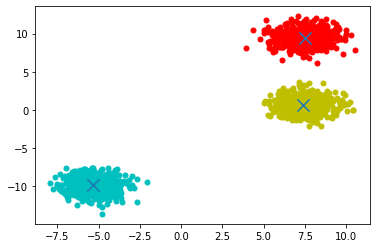

In [1096]:
colors = ["c.","r.", "y."]

for i in range(len(X_1)):
    #print("coordinate:",X_1[i], "label:", labels_X_1_k_2[i])
    plt.plot(X_1[i][0], X_1[i][1], colors[labels_X_1_k_3[i]], markersize = 10)


plt.scatter(centroids_3[:, 0],centroids_3[:, 1], marker = "x", s=150, linewidths = 5, zorder = 10)

plt.show()

In [1097]:
## k-mean clustering with n_clusters = 4 ##

kmeans_4 = KMeans(n_clusters=4)
kmeans_4.fit(X_1)
labels_X_1_k_4 = kmeans_4.predict(X_1)
centroids_4 = kmeans_4.cluster_centers_

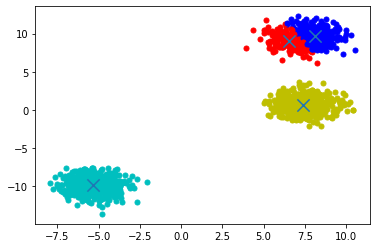

In [1098]:
colors = ["c.","r.", "y.", "b."]

for i in range(len(X_1)):
    #print("coordinate:",X_1[i], "label:", labels_X_1_k_2[i])
    plt.plot(X_1[i][0], X_1[i][1], colors[labels_X_1_k_4[i]], markersize = 10)


plt.scatter(centroids_4[:, 0],centroids_4[:, 1], marker = "x", s=150, linewidths = 5, zorder = 10)

plt.show()

In [1099]:
## cluster_2.csv ###

In [1100]:
## K-mean clustering with n_cluster = 2 ##

kmeans_2 = KMeans(n_clusters=2)
kmeans_2.fit(X_2)
labels_X_2_k_2 = kmeans_2.predict(X_2)
centroids_2 = kmeans_2.cluster_centers_

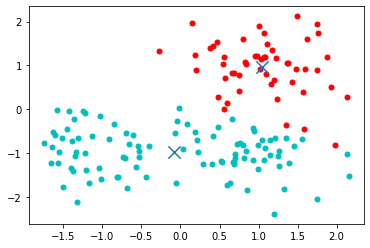

In [1101]:
colors = ["c.","r."]

for i in range(len(X_2)):
    #print("coordinate:",X_1[i], "label:", labels_X_1_k_2[i])
    plt.plot(X_2[i][0], X_2[i][1], colors[labels_X_2_k_2[i]], markersize = 10)


plt.scatter(centroids_2[:, 0],centroids_2[:, 1], marker = "x", s=150, linewidths = 5, zorder = 10)

plt.show()

In [1102]:
## K-mean clustering with n_cluster = 3 ##

kmeans_3 = KMeans(n_clusters=3)
kmeans_3.fit(X_3)
labels_X_2_k_3 = kmeans_3.predict(X_3)
centroids_3 = kmeans_3.cluster_centers_

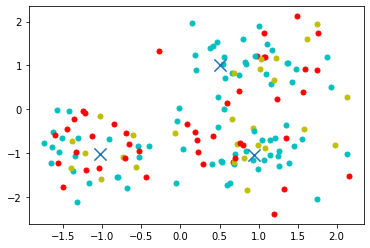

In [1103]:
colors = ["c.","r.", "y."]

for i in range(len(X_2)):
    #print("coordinate:",X_1[i], "label:", labels_X_1_k_2[i])
    plt.plot(X_2[i][0], X_2[i][1], colors[labels_X_2_k_3[i]], markersize = 10)


plt.scatter(centroids_3[:, 0],centroids_3[:, 1], marker = "x", s=150, linewidths = 5, zorder = 10)

plt.show()

In [1104]:
## k-mean clustering with n_clusters = 4 ##

kmeans_4 = KMeans(n_clusters=4)
kmeans_4.fit(X_2)
labels_X_2_k_4 = kmeans_4.predict(X_2)
centroids_4 = kmeans_4.cluster_centers_

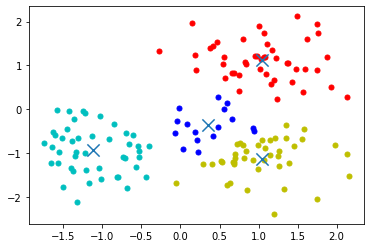

In [1105]:
colors = ["c.","r.", "y.", "b."]

for i in range(len(X_2)):
    #print("coordinate:",X_1[i], "label:", labels_X_1_k_2[i])
    plt.plot(X_2[i][0], X_2[i][1], colors[labels_X_2_k_4[i]], markersize = 10)


plt.scatter(centroids_4[:, 0],centroids_4[:, 1], marker = "x", s=150, linewidths = 5, zorder = 10)

plt.show()

In [1106]:
## cluster3.csv ##

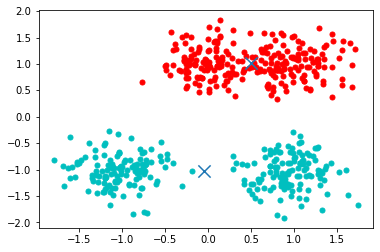

In [1107]:
## K-mean clustering with n_cluster = 2 ##

kmeans_2 = KMeans(n_clusters=2)
kmeans_2.fit(X_3)
labels_X_3_k_2 = kmeans_2.predict(X_3)
centroids_2 = kmeans_2.cluster_centers_

colors = ["c.","r."]

for i in range(len(X_3)):
    #print("coordinate:",X_1[i], "label:", labels_X_1_k_2[i])
    plt.plot(X_3[i][0], X_3[i][1], colors[labels_X_3_k_2[i]], markersize = 10)


plt.scatter(centroids_2[:, 0],centroids_2[:, 1], marker = "x", s=150, linewidths = 5, zorder = 10)

plt.show()




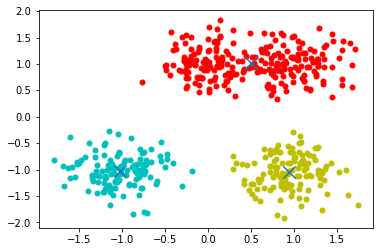

In [1108]:

## k-mean clustering with n_clusters = 3  ##

kmeans_3 = KMeans(n_clusters=3)
kmeans_3.fit(X_3)
labels_X_3_k_3 = kmeans_3.predict(X_3)
centroids_3 = kmeans_3.cluster_centers_

colors = ["c.","r.", "y."]

for i in range(len(X_3)):
    #print("coordinate:",X_1[i], "label:", labels_X_1_k_2[i])
    plt.plot(X_3[i][0], X_3[i][1], colors[labels_X_3_k_3[i]], markersize = 10)


plt.scatter(centroids_3[:, 0],centroids_3[:, 1], marker = "x", s=150, linewidths = 5, zorder = 10)

plt.show()



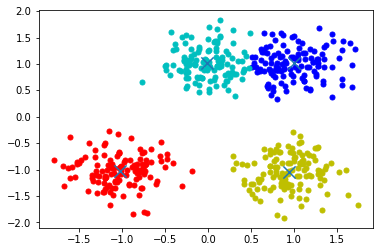

In [1109]:

## k-mean clustering with n_clusters = 4 ##

kmeans_4 = KMeans(n_clusters=4)
kmeans_4.fit(X_3)
labels_X_3_k_4 = kmeans_4.predict(X_3)
centroids_4 = kmeans_4.cluster_centers_

colors = ["c.","r.", "y.", "b."]

for i in range(len(X_3)):
    #print("coordinate:",X_1[i], "label:", labels_X_1_k_2[i])
    plt.plot(X_3[i][0], X_3[i][1], colors[labels_X_3_k_4[i]], markersize = 10)


plt.scatter(centroids_4[:, 0],centroids_4[:, 1], marker = "x", s=150, linewidths = 5, zorder = 10)

plt.show()



In [1110]:
## cluster4.csv ## 

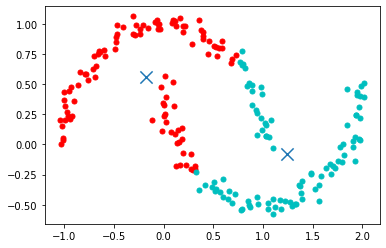

In [1111]:
## K-mean clustering with n_cluster = 2 ##

kmeans_2 = KMeans(n_clusters=2)
kmeans_2.fit(X_4)
labels_X_4_k_2 = kmeans_2.predict(X_4)
centroids_2 = kmeans_2.cluster_centers_

colors = ["c.","r."]

for i in range(len(X_4)):
    #print("coordinate:",X_1[i], "label:", labels_X_1_k_2[i])
    plt.plot(X_4[i][0], X_4[i][1], colors[labels_X_4_k_2[i]], markersize = 10)


plt.scatter(centroids_2[:, 0],centroids_2[:, 1], marker = "x", s=150, linewidths = 5, zorder = 10)

plt.show()




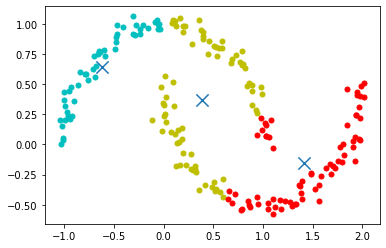

In [1112]:
## k-mean clustering with n_clusters = 3  ##

kmeans_3 = KMeans(n_clusters=3)
kmeans_3.fit(X_4)
labels_X_4_k_3 = kmeans_3.predict(X_4)
centroids_3 = kmeans_3.cluster_centers_

colors = ["c.","r.", "y."]

for i in range(len(X_4)):
    #print("coordinate:",X_1[i], "label:", labels_X_1_k_2[i])
    plt.plot(X_4[i][0], X_4[i][1], colors[labels_X_4_k_3[i]], markersize = 10)


plt.scatter(centroids_3[:, 0],centroids_3[:, 1], marker = "x", s=150, linewidths = 5, zorder = 10)

plt.show()


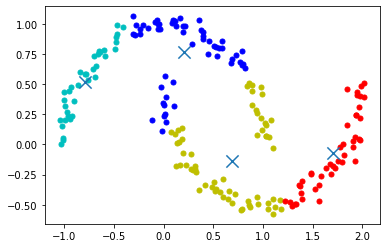

In [1113]:

## k-mean clustering with n_clusters = 4 ##

kmeans_4 = KMeans(n_clusters=4)
kmeans_4.fit(X_4)
labels_X_4_k_4 = kmeans_4.predict(X_4)
centroids_4 = kmeans_4.cluster_centers_

colors = ["c.","r.", "y.", "b."]

for i in range(len(X_4)):
    #print("coordinate:",X_1[i], "label:", labels_X_1_k_2[i])
    plt.plot(X_4[i][0], X_4[i][1], colors[labels_X_4_k_4[i]], markersize = 10)


plt.scatter(centroids_4[:, 0],centroids_4[:, 1], marker = "x", s=150, linewidths = 5, zorder = 10)

plt.show()



In [1114]:
# End your code (multiple cells)

<h3 style="color:rgb(208,90,80)">Question 2:</h3>

Your answer here.

Use the provided labels to determine which algorithm and which number of clusters give better results on a specific data set and explain why one algorithm might have an advantage over the other one.

Questions:

Which method is faster?
Which method performs best in each dataset?
Is any dataset not "solved" by the  𝑘 -means or Affinity Propagation? Why? Which parameters could be modified for improvement?

Which method is faster?

To answer the question, it really depends on the volume of a given dataset and its complexity such as attributes and data homogeneity. In general, the K-mean method represents faster than the affinity propagation method. A crucial reason for this outcome is that an algorithm with the affinity propagation has to compute a similarity matrix which is quite a time and memory demanding work in case of dealing with a volume of the dataset.

Which method performs best in each dataset?

For "cluster1.csv", the K-mean method shows better performance for classification clustering over the affinity propagation(AF). To be more specified that, some of the AF methods could not converge to make clusters or classification for the dataset in the min and the median value of preference option.

For "cluster2.csv", the AF method seems to be better performance over its competitor. However, the k-mean method represents a concrete classification performance when it uses a higher number of clusters (4) compared to the other results.

For "cluster3.csv", it clearly recognizes that the method of K-mean clustering returned a better result compared to the results from the AF method.

For "cluster4.csv", as the shape of the dataset, the k-mean clustering has a limitation to making a classification of the dataset by the given numbers of clusterings. In this case, the affinity propagation seems to be more desirable method than the K-mean. Actually, the Spectral clustering method will be the best algorithm to be applied for the dataset.

Is any dataset not "solved" by the  𝑘 -means or Affinity Propagation? Why? Which parameters could be modified for improvement?

Using the AffinityPropagation method, some of the cases returned "unsolved" or "not converged" outcomes. There are several reasons to support the "unsolved" cases. A reason could be the nature of the dataset is not favorable to make clusters by the AF method. As well, the parameters applied to the AF method during the experiments were not optimized. Optimized parameters of either "damping" or "preference" could be improved a better clustering result. 
In the K-mean clustering method for the experiment, the different numbers of clustering used for the comparison. Therefore, a proper number of clustering is essential to conduct an experiment using the K-Mean. There are several parameters can be modified with the library such as maximum iteration and algorithm to select/compute the nearest neighbors 
